# Estimating archaic TMRCAs from the real data

In [453]:
library(tidyverse)
library(magrittr)
library(here)
library(furrr)
library(scales)
library(lemon)
library(cowplot)

devtools::load_all(".")

plan(multiprocess)


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading ychr


In [2]:
highcov_gt <- read_vcf(here("data/vcf/full_highcov.vcf.gz"), mindp = 3, maxdp = 0.975)

In [3]:
tafr <- calculate_tafr(highcov_gt)

In [4]:
tafr %>% group_by(afr) %>% unnest(counts_afr) %>% summarise_if(is.numeric, mean)

afr tmrca_afr tmrca_ad tmrca_f  mut_rate    age   a        b         c       
1 a00 265414.8  286711.4 244118.1 7.14796e-10 45000 964.6154 0.1538462 7.384615
  d        e        f        total  
1 194.4615 11.84615 986.3846 5677799

In [5]:
tmrca_full_low <-
    map_dfr(c("den4", "den8", "spy1", "shotgun_mez2", "shotgun_spy1"), function(arch) {
        map_dfr(c("all", "tv_only"), function(sites) {
            future_map_dfr(1:8, function(dp) {
                read_genotypes(arch, "full", mindp = dp, maxdp = 0.975, tv_only = sites == "tv_only") %>%
                    calculate_tarch(tafr) %>%
                    mutate(dp = dp, sites = sites)
            })
        })
    })

In [8]:
tmrca_full_high <-
    map_dfr(c("mez2", "mez2_snpad"), function(arch) {
        map_dfr(c("all", "tv_only"), function(sites) {
            future_map_dfr(1:20, function(dp) {
                read_genotypes(arch, "full", mindp = dp, maxdp = 0.975, tv_only = sites == "tv_only") %>%
                    calculate_tarch(tafr) %>%
                    mutate(dp = dp, sites = sites)
            })
        })
    })

In [10]:
tmrca_full_subsampled <-
    map_dfr(paste0("mez2_dp", 1:10), function(arch) {
        map_dfr(c("all", "tv_only"), function(sites) {
            future_map_dfr(1:10, function(dp) {
                read_genotypes(arch, "full", mindp = dp, maxdp = 0.975, tv_only = sites == "tv_only") %>%
                    calculate_tarch(tafr) %>%
                    mutate(dp = dp, sites = sites)
            })
        })
    })

In [11]:
tmrca_lippold <-
    map_dfr(c("elsidron2"), function(arch) {
        map_dfr(c("all", "tv_only"), function(sites) {
            future_map_dfr(1:20, function(dp) {
                read_genotypes(arch, "lippold", mindp = dp, maxdp = 0.975, tv_only = sites == "tv_only") %>%
                    calculate_tarch(tafr) %>%
                    mutate(dp = dp, sites = sites)
            })
        })
    })

In [12]:
tmrca_exome <-
    map_dfr(c("elsidron1"), function(arch) {
        map_dfr(c("all", "tv_only"), function(sites) {
            future_map_dfr(1:8, function(dp) {
                read_genotypes(arch, "exome", mindp = dp, maxdp = 0.975, tv_only = sites == "tv_only") %>%
                    calculate_tarch(tafr) %>%
                    mutate(dp = dp, sites = sites)
            })
        })
    })

In [13]:
tmrca_full_low        %<>% mutate(capture = "full")
tmrca_full_high       %<>% mutate(capture = "full")
tmrca_full_subsampled %<>% mutate(capture = "full")
tmrca_lippold         %<>% mutate(capture = "lippold")
tmrca_exome           %<>% mutate(capture = "exome")

In [21]:
tmrca_df <- bind_rows(tmrca_full_low, tmrca_full_high, tmrca_full_subsampled, tmrca_lippold, tmrca_exome)

In [22]:
saveRDS(tmrca_df, here("data/rds/tmrca_df.rds"))

# Minimum coverage cutoff vs branch counts (how low can we go?)

There needs to be a balance between:

* avoiding false SNPs due to low coverage
* mapping only reference-like sites

The `f` branch (length of the private archaic lineage) is a good measure for this. It is expected to be very long when the lower cutoff is low (for example, all DNA damage and sequencing errors will manifest as true SNPs when using even single reads), but shorten as we increase the cutoff. The danger is, of course, that a very strict filtering cutoff will allow only sites in reference-like regions to be considered.

Using the `e` branch counts as in Mendez et al. unreliable, because it changes significantly with coverage cutoffs. Luckily, the `d` and `a` branches become relatively stable with lower coverage cutoff as low as 3X. It is easy to derive a formula for $\alpha$ that avoid `e` completely.

In [856]:
dp_branches <- tmrca_df %>%
    mutate(arch = str_replace(arch, "mez2_dp(\\d+)", "\\1X"),
           arch = factor(arch, levels = paste0(1:8, "X"))) %>%
    filter(capture == "full", arch %in% paste0(1:8, "X"), sites == "all", dp <= 7) %>%
    unnest(counts_arch) %>%
    mutate(n_muts = a + b + c + d + e + f) %>%
    select(arch, dp, tmrca_arch, alpha, a, b, c, d, e, f, total, n_muts, sites) %>%
    gather(branch, count, -c(arch, dp, alpha, tmrca_arch, total, n_muts, sites)) %>% 
    mutate(prop = count / n_muts,
           dp = factor(dp))

In [857]:
dp_branches_top <- dp_branches %>% select(arch, dp, sites, branch, prop) %>% group_by(arch, dp, sites, branch) %>% top_n(1, prop) %>% rename(max_prop = prop)
dp_branches_bottom <- dp_branches %>% select(arch, dp, sites, branch, prop) %>% group_by(arch, dp, sites, branch) %>% top_n(-1, prop) %>% rename(min_prop = prop)

Joining, by = c("arch", "dp", "sites", "branch")
Warning message:
“Removed 24 rows containing missing values (geom_point).”Warning message:
“Removed 24 rows containing missing values (geom_point).”

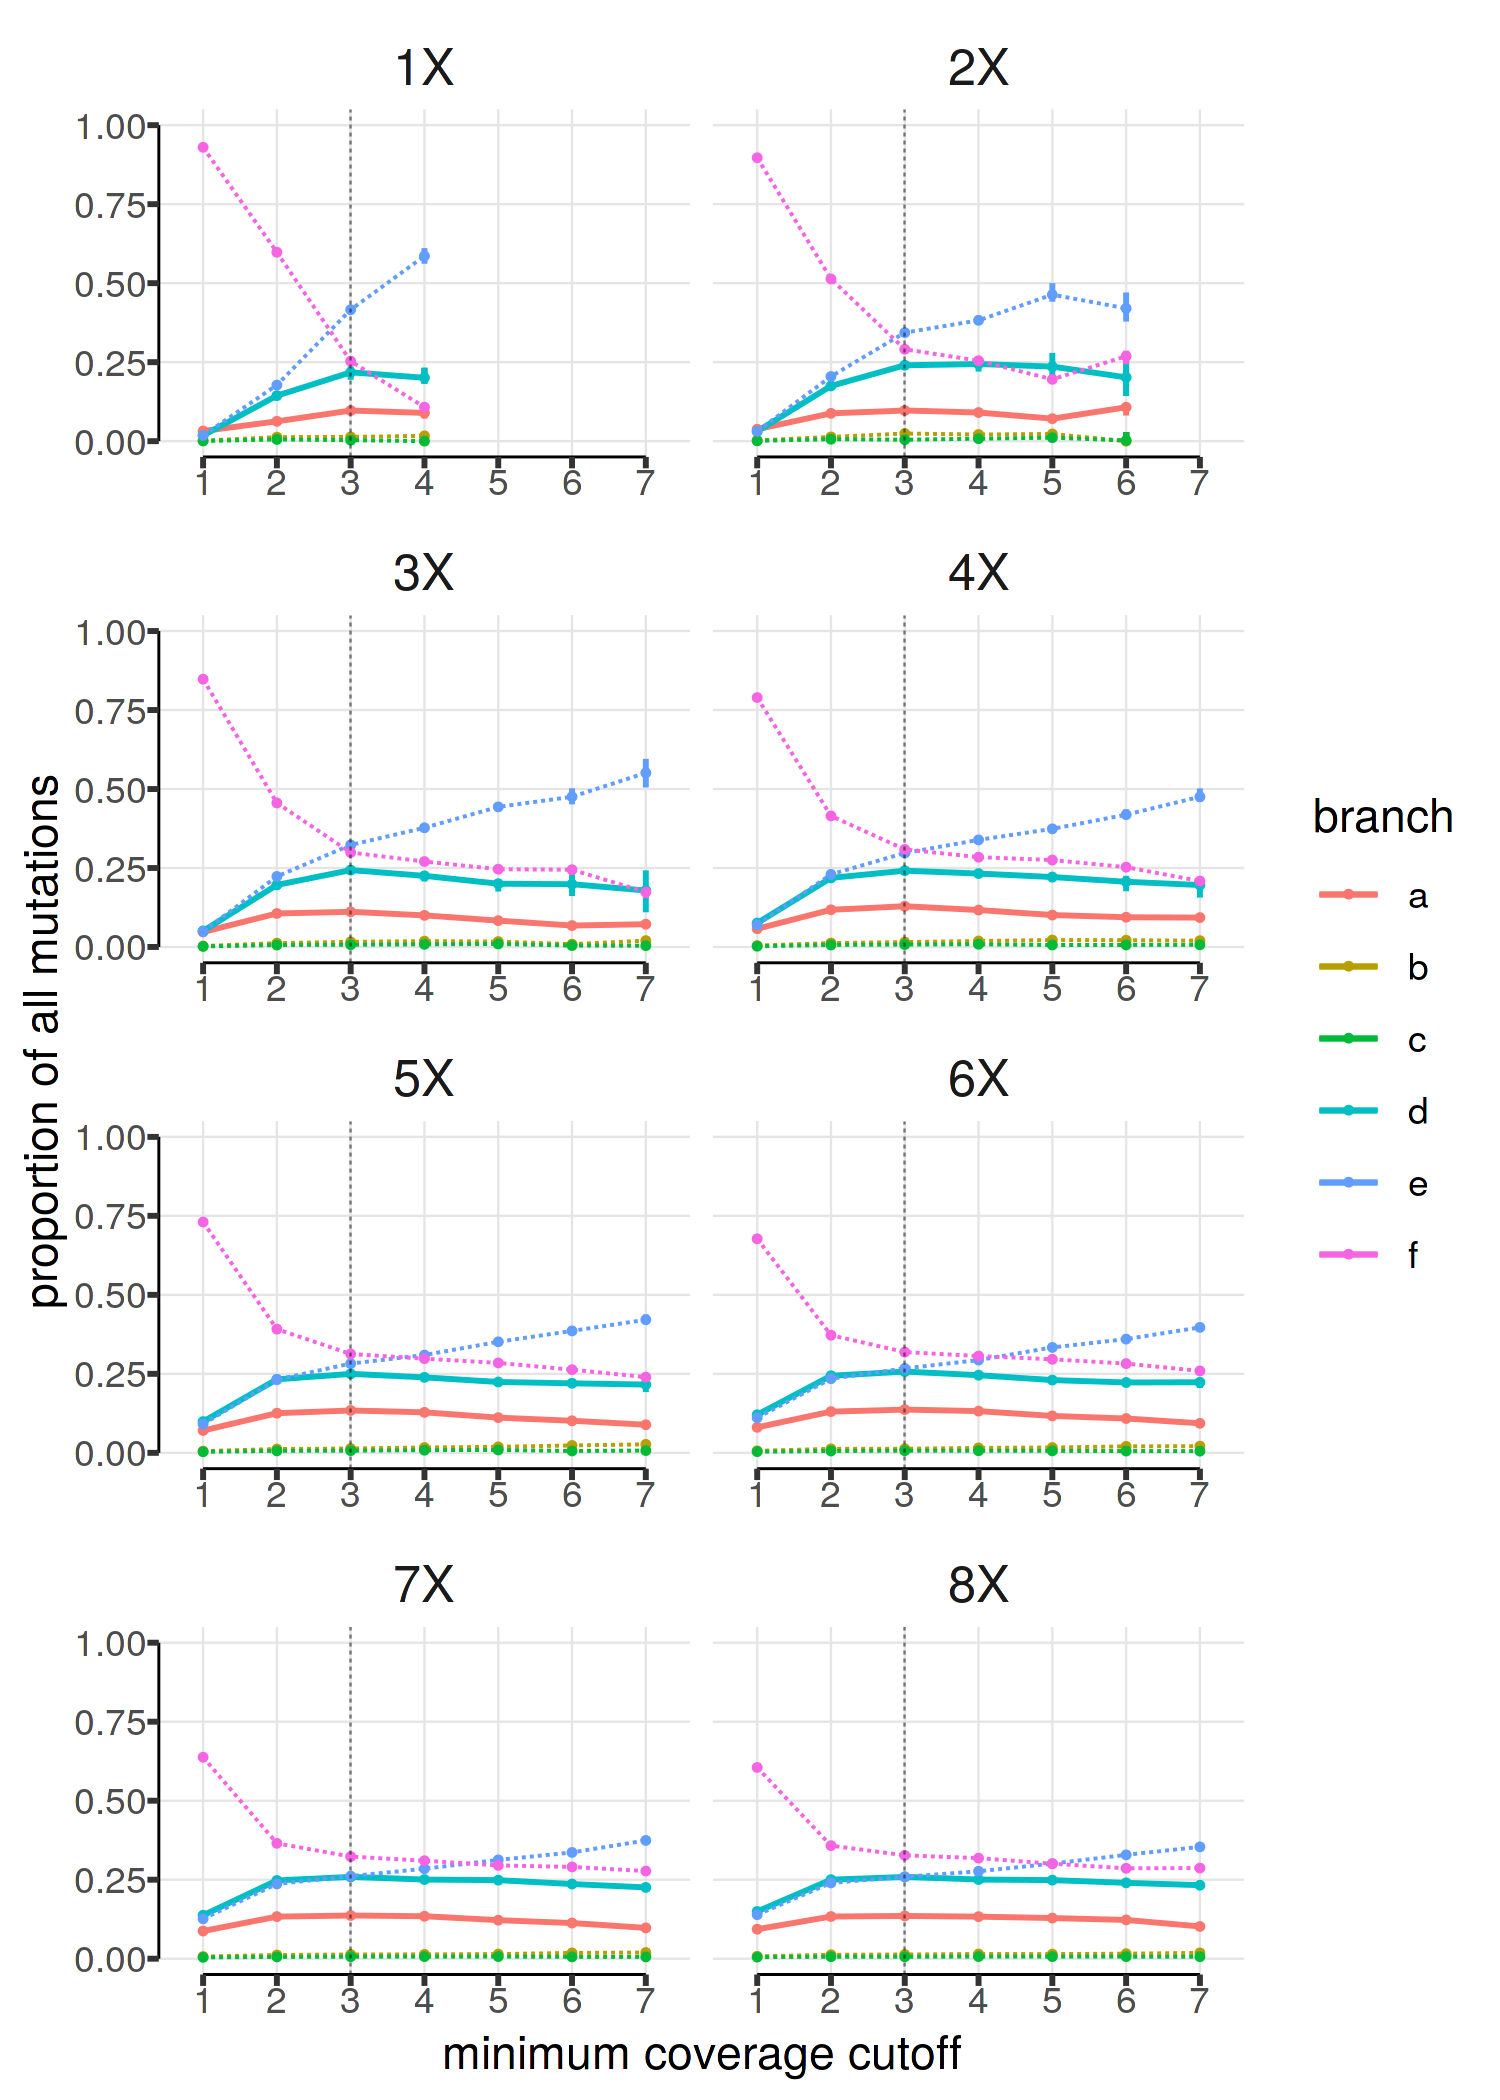

In [876]:
set_dim(5, 7)

ggplot() +
    geom_errorbar(data = inner_join(dp_branches_top, dp_branches_bottom),
                  aes(x = dp, ymin = min_prop, ymax = max_prop, color = branch), width = 0) +
    geom_line(data = filter(dp_branches, branch %in% c("a", "d")) %>%
                            group_by(arch, dp, sites, branch) %>%
                            summarise_if(is.numeric, mean),
              aes(dp, prop, color = branch, group = branch), linetype = 1) +
    geom_line(data = filter(dp_branches, !branch %in% c("a", "d")) %>%
                            group_by(arch, dp, sites, branch) %>%
                            summarise_if(is.numeric, mean),
              aes(dp, prop, color = branch, group = branch), linetype = 2, size = 1/3) +
    geom_point(data = group_by(dp_branches, arch, dp, sites, branch) %>% summarise_if(is.numeric, mean),
               aes(dp, prop, color = branch), size = 1/3) +
    geom_vline(xintercept = 3, linetype = 2, size = 1/5, alpha = 1/2, color = "black") +
    theme_bw() +
    theme(
        panel.border=element_blank(), 
        strip.text.x = element_text(size = 12),
        strip.background = element_blank(),
        axis.line = element_line(size = 1/4),
        legend.position = "right"
    ) +
    xlab("minimum coverage cutoff") +
    ylab("proportion of all mutations") +
    background_grid(major = "xy", minor = "none") +
    coord_capped_cart(ylim = c(0, 1), bottom = "both", left = "both") +
    facet_wrap(~ arch, ncol = 2, scales = "free_x") +
    guides(col = guide_legend(ncol = 1), linetype = FALSE)

ggsave(here("figures/branch_proportions_dp.png"), width = 5, height = 7)

# Same analysis but for all archaic Y chromosomes

In [868]:
arch_branches <- tmrca_df %>%
    filter(capture == "lippold" & arch == "elsidron2" | capture == "full" & arch %in% c("mez2", "spy1", "den4", "den8"), sites == "all", dp <= 7) %>%
    mutate(arch = fix_name(arch)) %>%
    unnest(counts_arch) %>%
    mutate(n_muts = a + b + c + d + e + f) %>%
    select(arch, dp, tmrca_arch, alpha, a, b, c, d, e, f, total, n_muts, sites) %>%
    gather(branch, count, -c(arch, dp, alpha, tmrca_arch, total, n_muts, sites)) %>% 
    mutate(prop = count / n_muts,
           dp = factor(dp)) %>%
    mutate(arch = fct_relevel(arch, "El Sidrón 1253", after = Inf))

In [870]:
arch_branches_top    <- select(arch_branches, arch, dp, sites, branch, prop) %>% group_by(arch, dp, sites, branch) %>% top_n(1, prop) %>% rename(max_prop = prop)
arch_branches_bottom <- select(arch_branches, arch, dp, sites, branch, prop) %>% group_by(arch, dp, sites, branch) %>% top_n(-1, prop) %>% rename(min_prop = prop)

Joining, by = c("arch", "dp", "sites", "branch")
Warning message:
“Removed 18 rows containing missing values (geom_point).”Warning message:
“Removed 18 rows containing missing values (geom_point).”

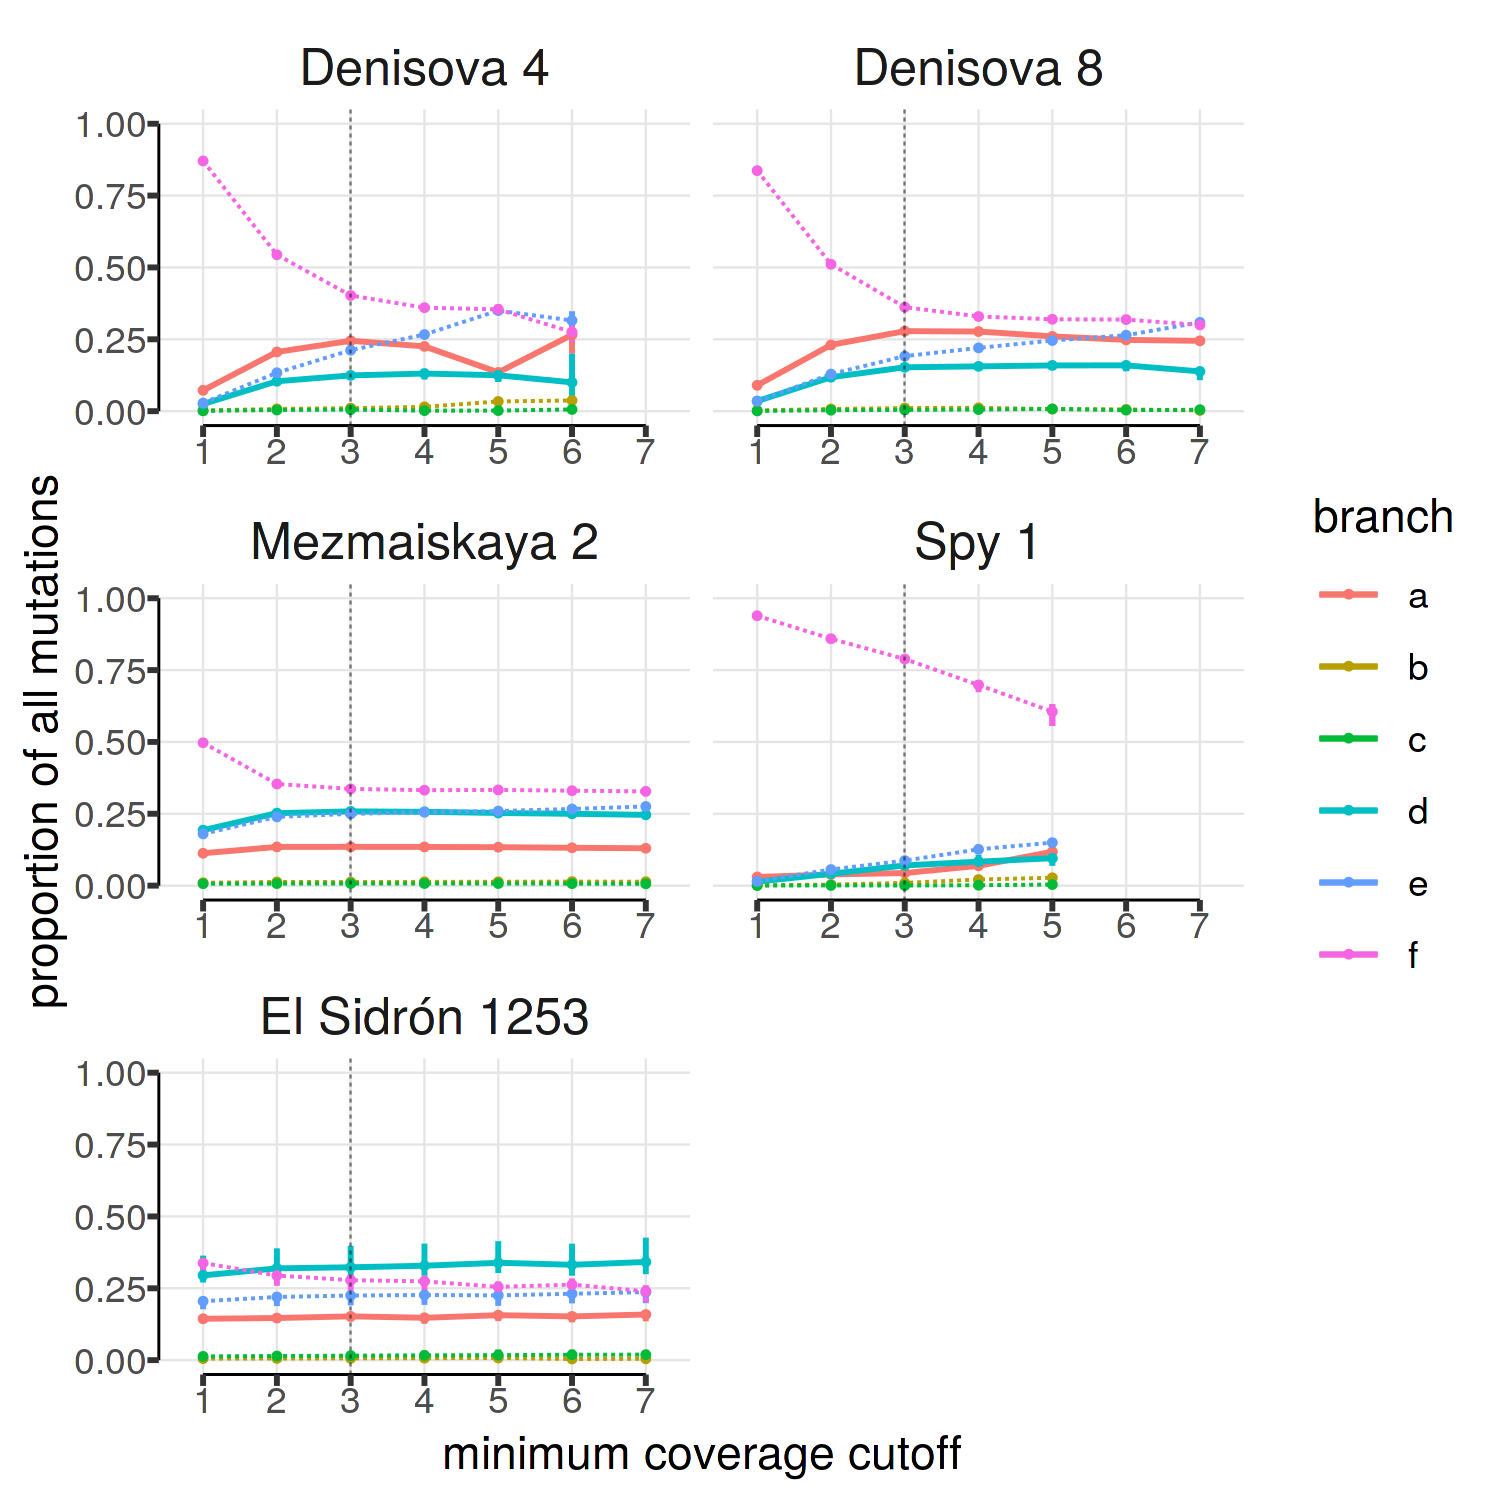

In [878]:
set_dim(5, 5)

ggplot() +
    geom_errorbar(data = inner_join(arch_branches_top, arch_branches_bottom),
                  aes(x = dp, ymin = min_prop, ymax = max_prop, color = branch), width = 0) +
    geom_line(data = filter(arch_branches, branch %in% c("a", "d")) %>%
                            group_by(arch, dp, sites, branch) %>%
                            summarise_if(is.numeric, mean),
              aes(dp, prop, color = branch, group = branch), linetype = 1) +
    geom_line(data = filter(arch_branches, !branch %in% c("a", "d")) %>%
                            group_by(arch, dp, sites, branch) %>%
                            summarise_if(is.numeric, mean),
              aes(dp, prop, color = branch, group = branch), linetype = 2, size = 1/3) +
    geom_point(data = group_by(arch_branches, arch, dp, sites, branch) %>% summarise_if(is.numeric, mean),
               aes(dp, prop, color = branch), size = 1/3) +
    geom_vline(xintercept = 3, linetype = 2, size = 1/5, alpha = 1/2, color = "black") +
    theme_bw() +
    theme(
        panel.border=element_blank(), 
        strip.text.x = element_text(size = 12),
        strip.background = element_blank(),
        axis.line = element_line(size = 1/4),
        legend.position = "right"
    ) +
    xlab("minimum coverage cutoff") +
    ylab("proportion of all mutations") +
    background_grid(major = "xy", minor = "none") +
    coord_capped_cart(ylim = c(0, 1), bottom = "both", left = "both") +
    facet_wrap(~ arch, ncol = 2, scales = "free_x") +
    guides(col = guide_legend(ncol = 1), linetype = FALSE)

ggsave(here("figures/branch_proportions_arch.png"), width = 5, height = 5)

# Lower coverage cutoff of 3X seems to be sufficient to remove the errors!
<br><br><br><br><br><br>

### TMRCA vs coverage

In [ ]:
set_dim(8, 5)

tmrca_df %>%
filter(dp <= 7, capture == "full" & arch %in% c("den8", "mez2", "mez2_dp3")) %>%
unnest(counts_arch) %>%
mutate(alpha2 = (a + d) / d, tmrca_arch2 = alpha2 * tmrca_f) %>%
mutate(alpha3 = (2 * a + d + e) / (d + e), tmrca_arch3 = alpha3 * tmrca_f) %>%
select(arch, tmrca_arch, tmrca_arch2, tmrca_arch3, sites, dp) %>% ggplot(aes(tmrca_arch, tmrca_arch3)) +geom_point()

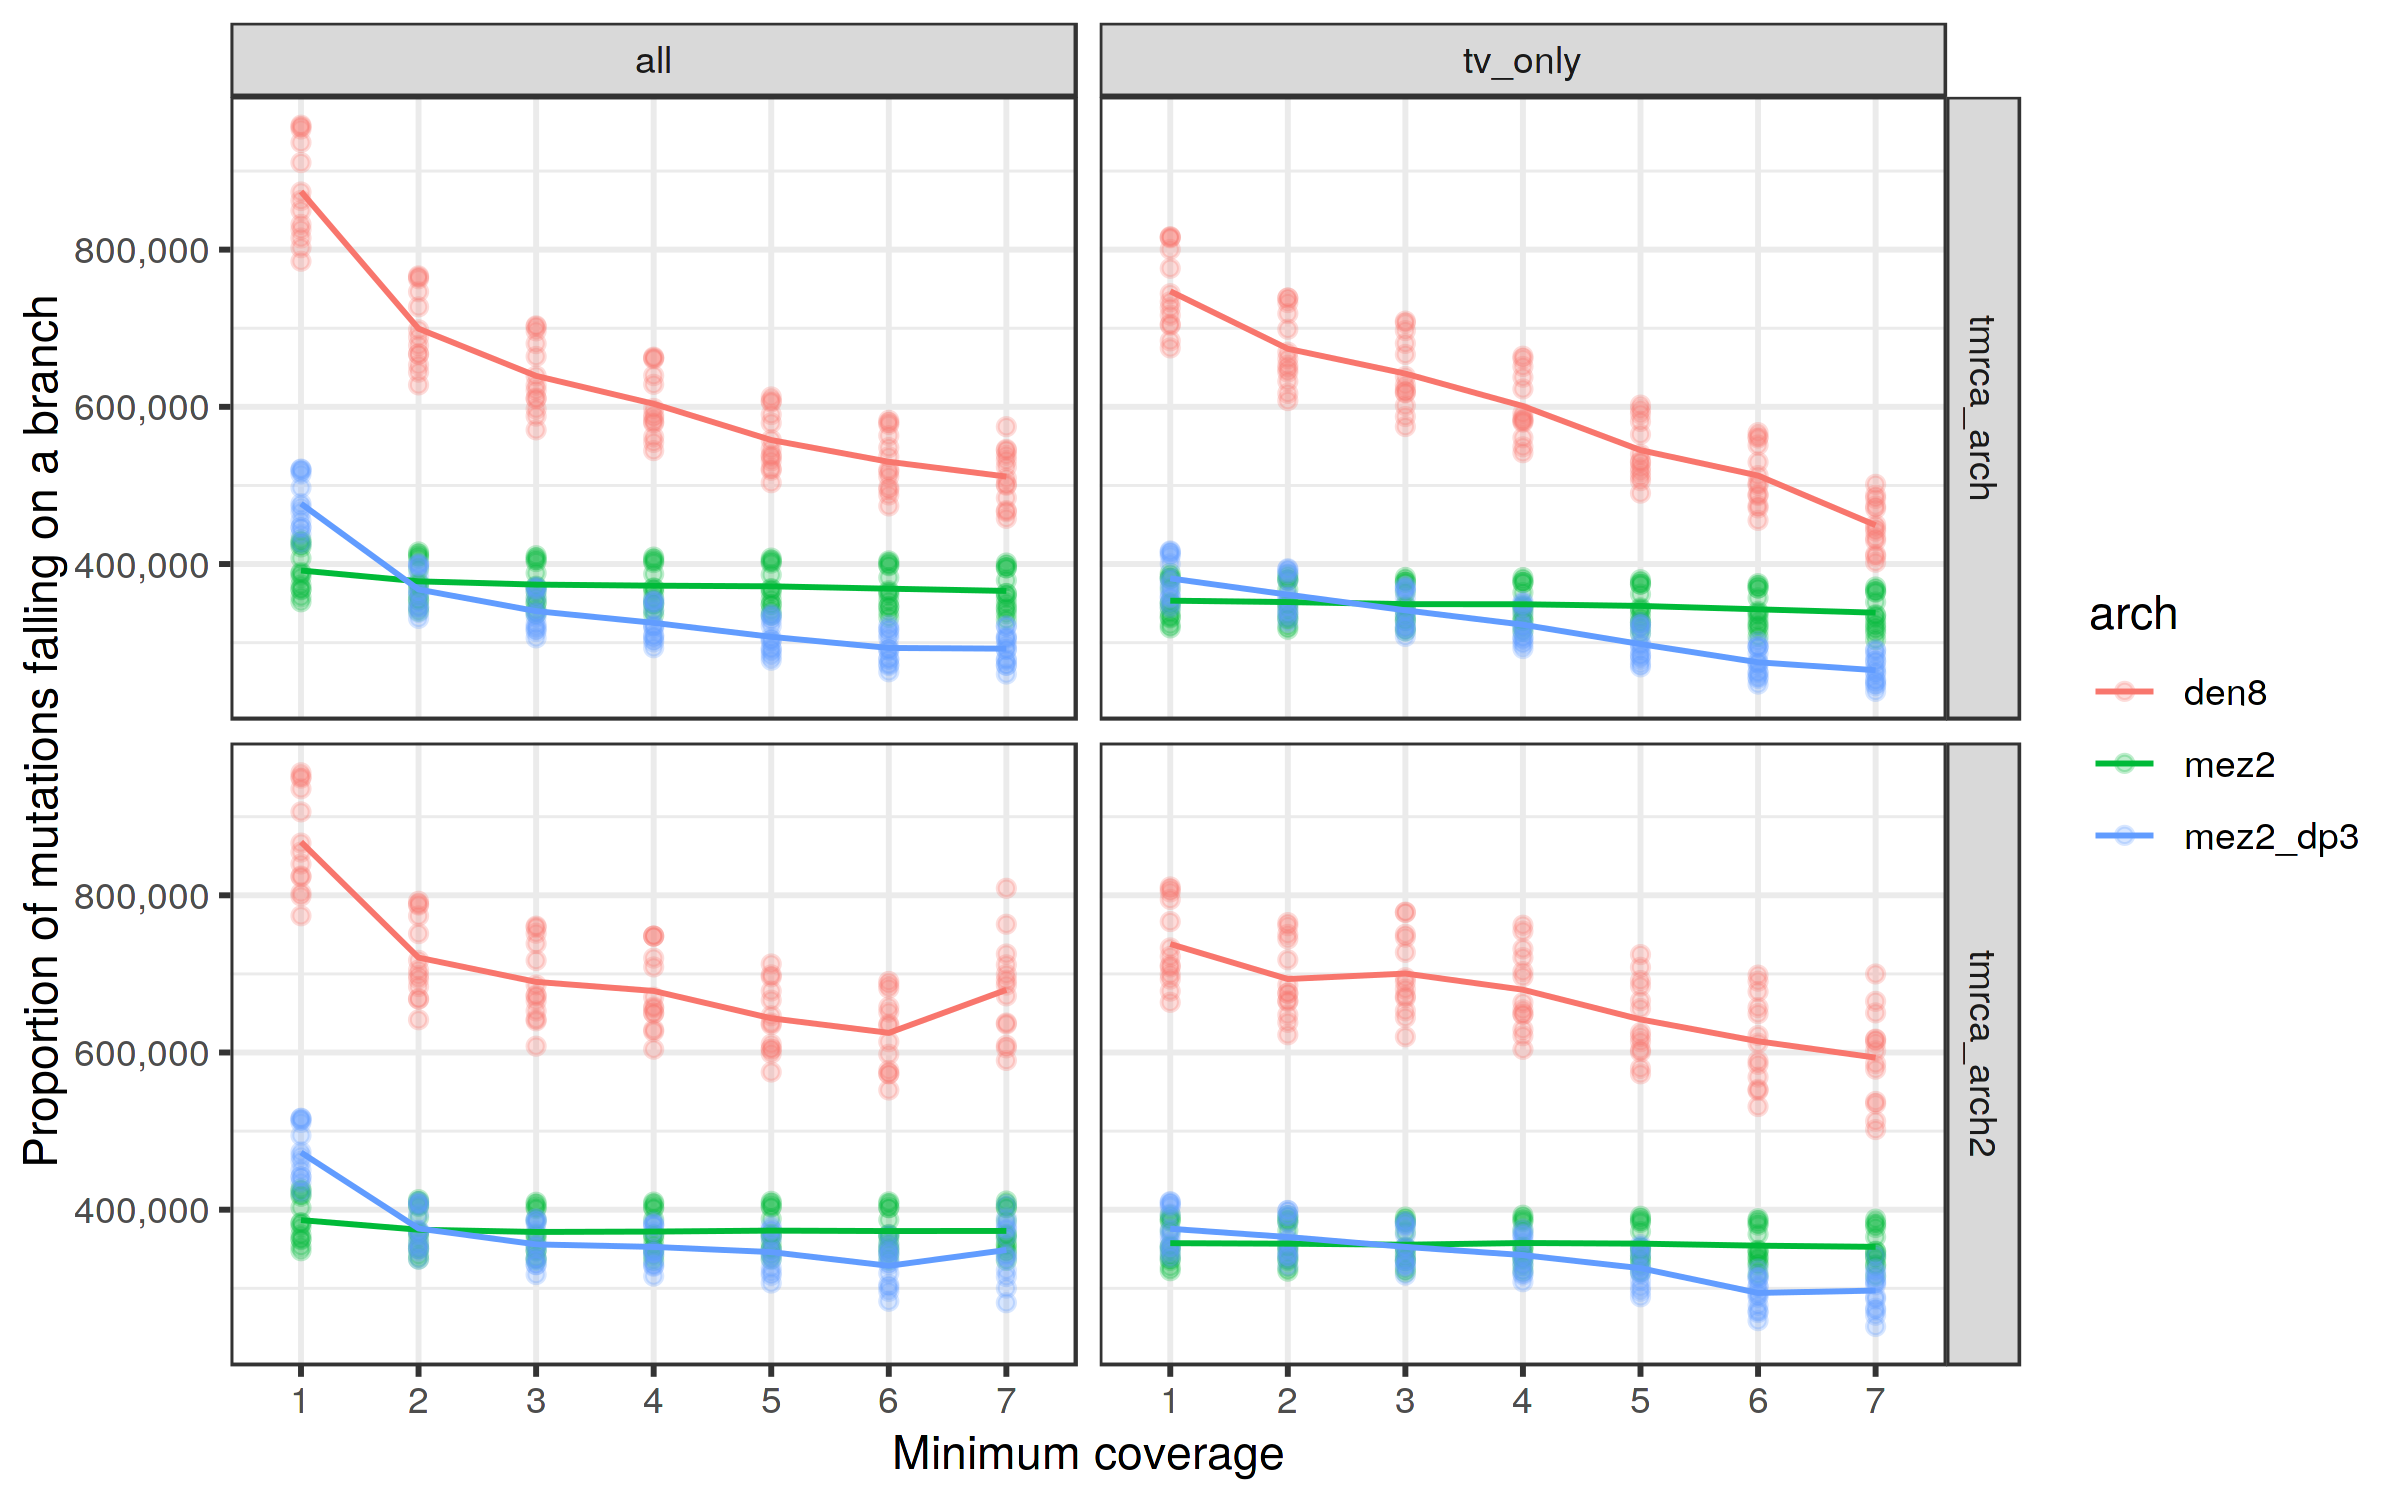

In [644]:
set_dim(8, 5)

tmrca_df %>%
filter(dp <= 7, capture == "full" & arch %in% c("den8", "mez2", "mez2_dp3")) %>%
unnest(counts_arch) %>%
mutate(alpha2 = (a + d) / d, tmrca_arch2 = alpha2 * tmrca_f) %>%
mutate(alpha3 = (2 * a + d + e) / (d + e), tmrca_arch3 = alpha3 * tmrca_f) %>%
select(arch, tmrca_arch, tmrca_arch2, tmrca_arch3, sites, dp) %>%
gather(tmrca, value, -c(arch, sites, dp)) %>%
filter(!is.na(value), !is.infinite(value)) %>% {
ggplot(., aes(as.factor(dp), value, color = arch, group = arch)) +
    geom_point(alpha = 1/4) +
    geom_line(data = group_by(., arch, sites, dp, tmrca) %>% summarise_all(mean), size = 1 / 2) +
    facet_grid(tmrca ~ sites) +
    theme_bw() +
    scale_y_continuous(labels = comma) +
    xlab("Minimum coverage") +
    ylab("Proportion of mutations falling on a branch")
}

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
“Removed 6 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 5 rows containing missing values (geom_point).”

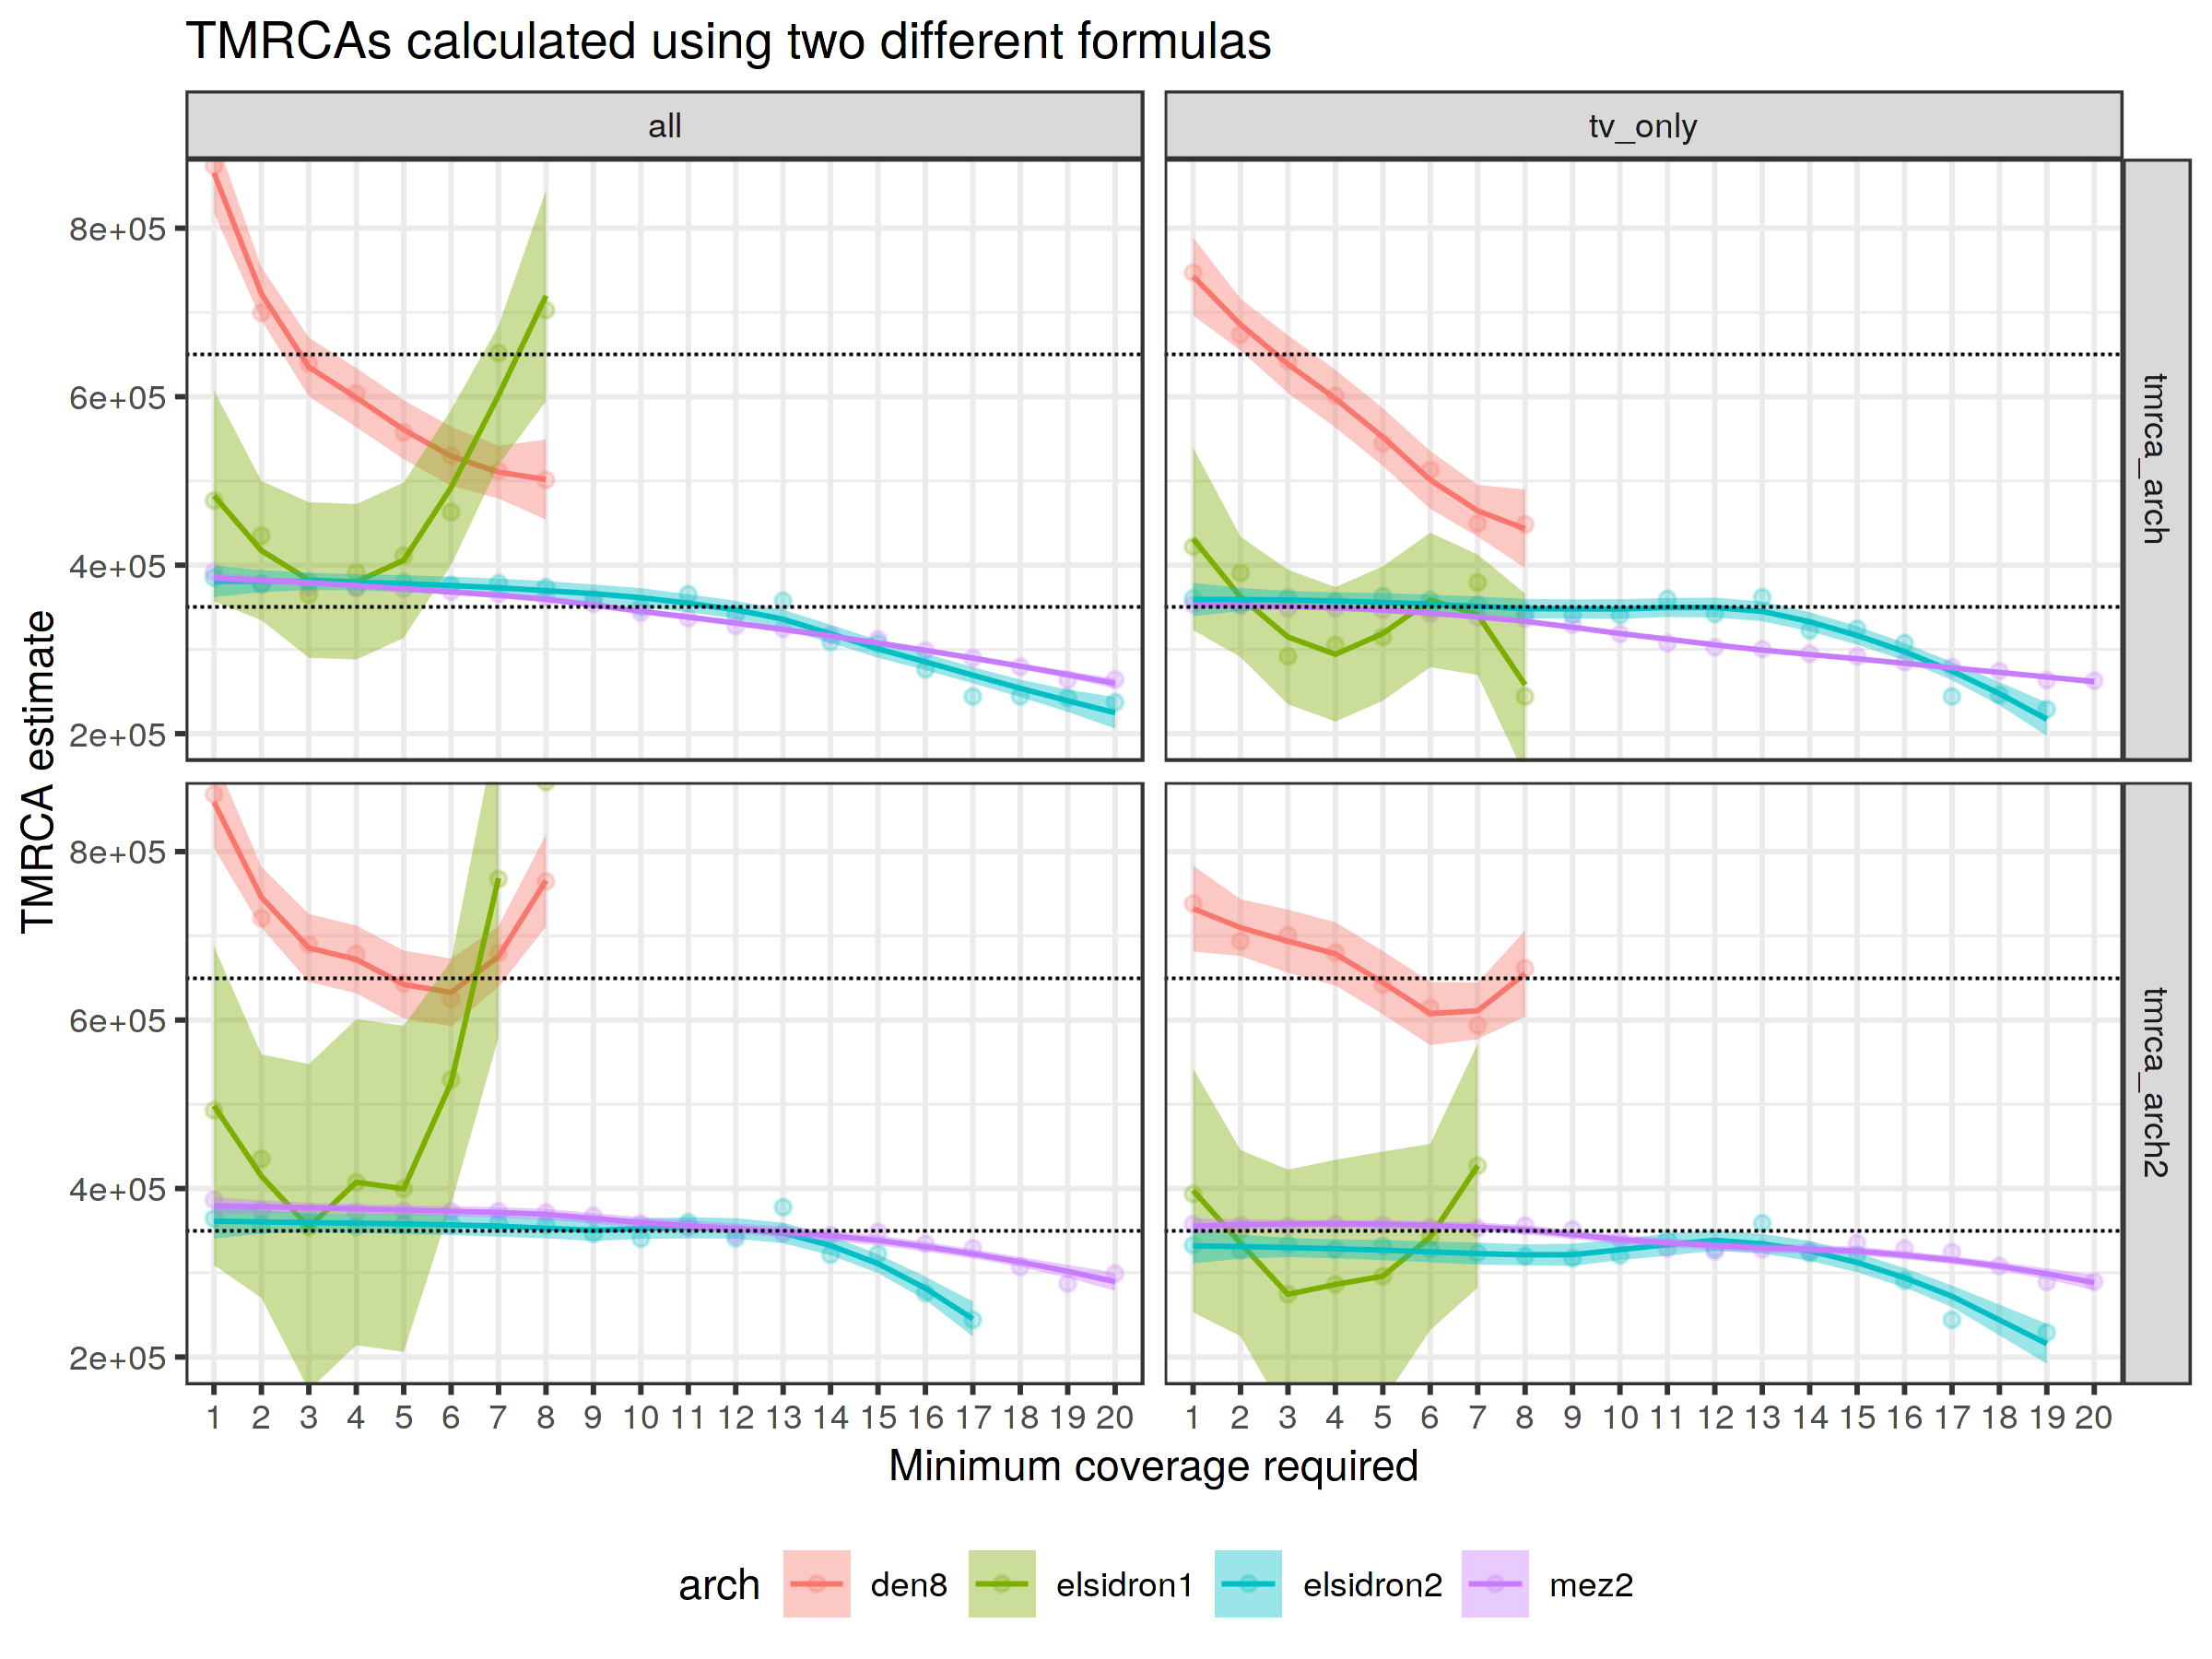

In [128]:
set_dim(8, 6)

tmrca_df %>%
filter(afr == "a00") %>%
filter(capture == "full" & arch %in% c("den8", "mez2") | capture == "lippold" & arch == "elsidron2" | capture == "exome" & arch == "elsidron1") %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
unnest(counts_arch) %>%
mutate(alpha2 = (a + d) / d, tmrca_arch2 = alpha2 * tmrca_f) %>%
select(arch, tmrca_arch, tmrca_arch2, sites, dp) %>%
group_by(arch, sites, dp) %>% summarise_all(mean) %>% 
gather(tmrca, value, -c(arch, sites, dp)) %>%
ggplot(aes(dp, value, color = arch)) +
    geom_point(aes(as.factor(dp), value), alpha = 1/4) +
    geom_smooth(aes(fill = arch), size = 0.5) +
    labs(x = "Minimum coverage required", y = "TMRCA estimate") +
    theme_bw() +
    coord_cartesian(y = c(200000, 850000)) +
    facet_grid(tmrca ~ sites) +
    theme(legend.position = "bottom") +
    ggtitle("TMRCAs calculated using two different formulas") +
    geom_hline(yintercept = c(350000, 650000), linetype = 2, size = 1/3)

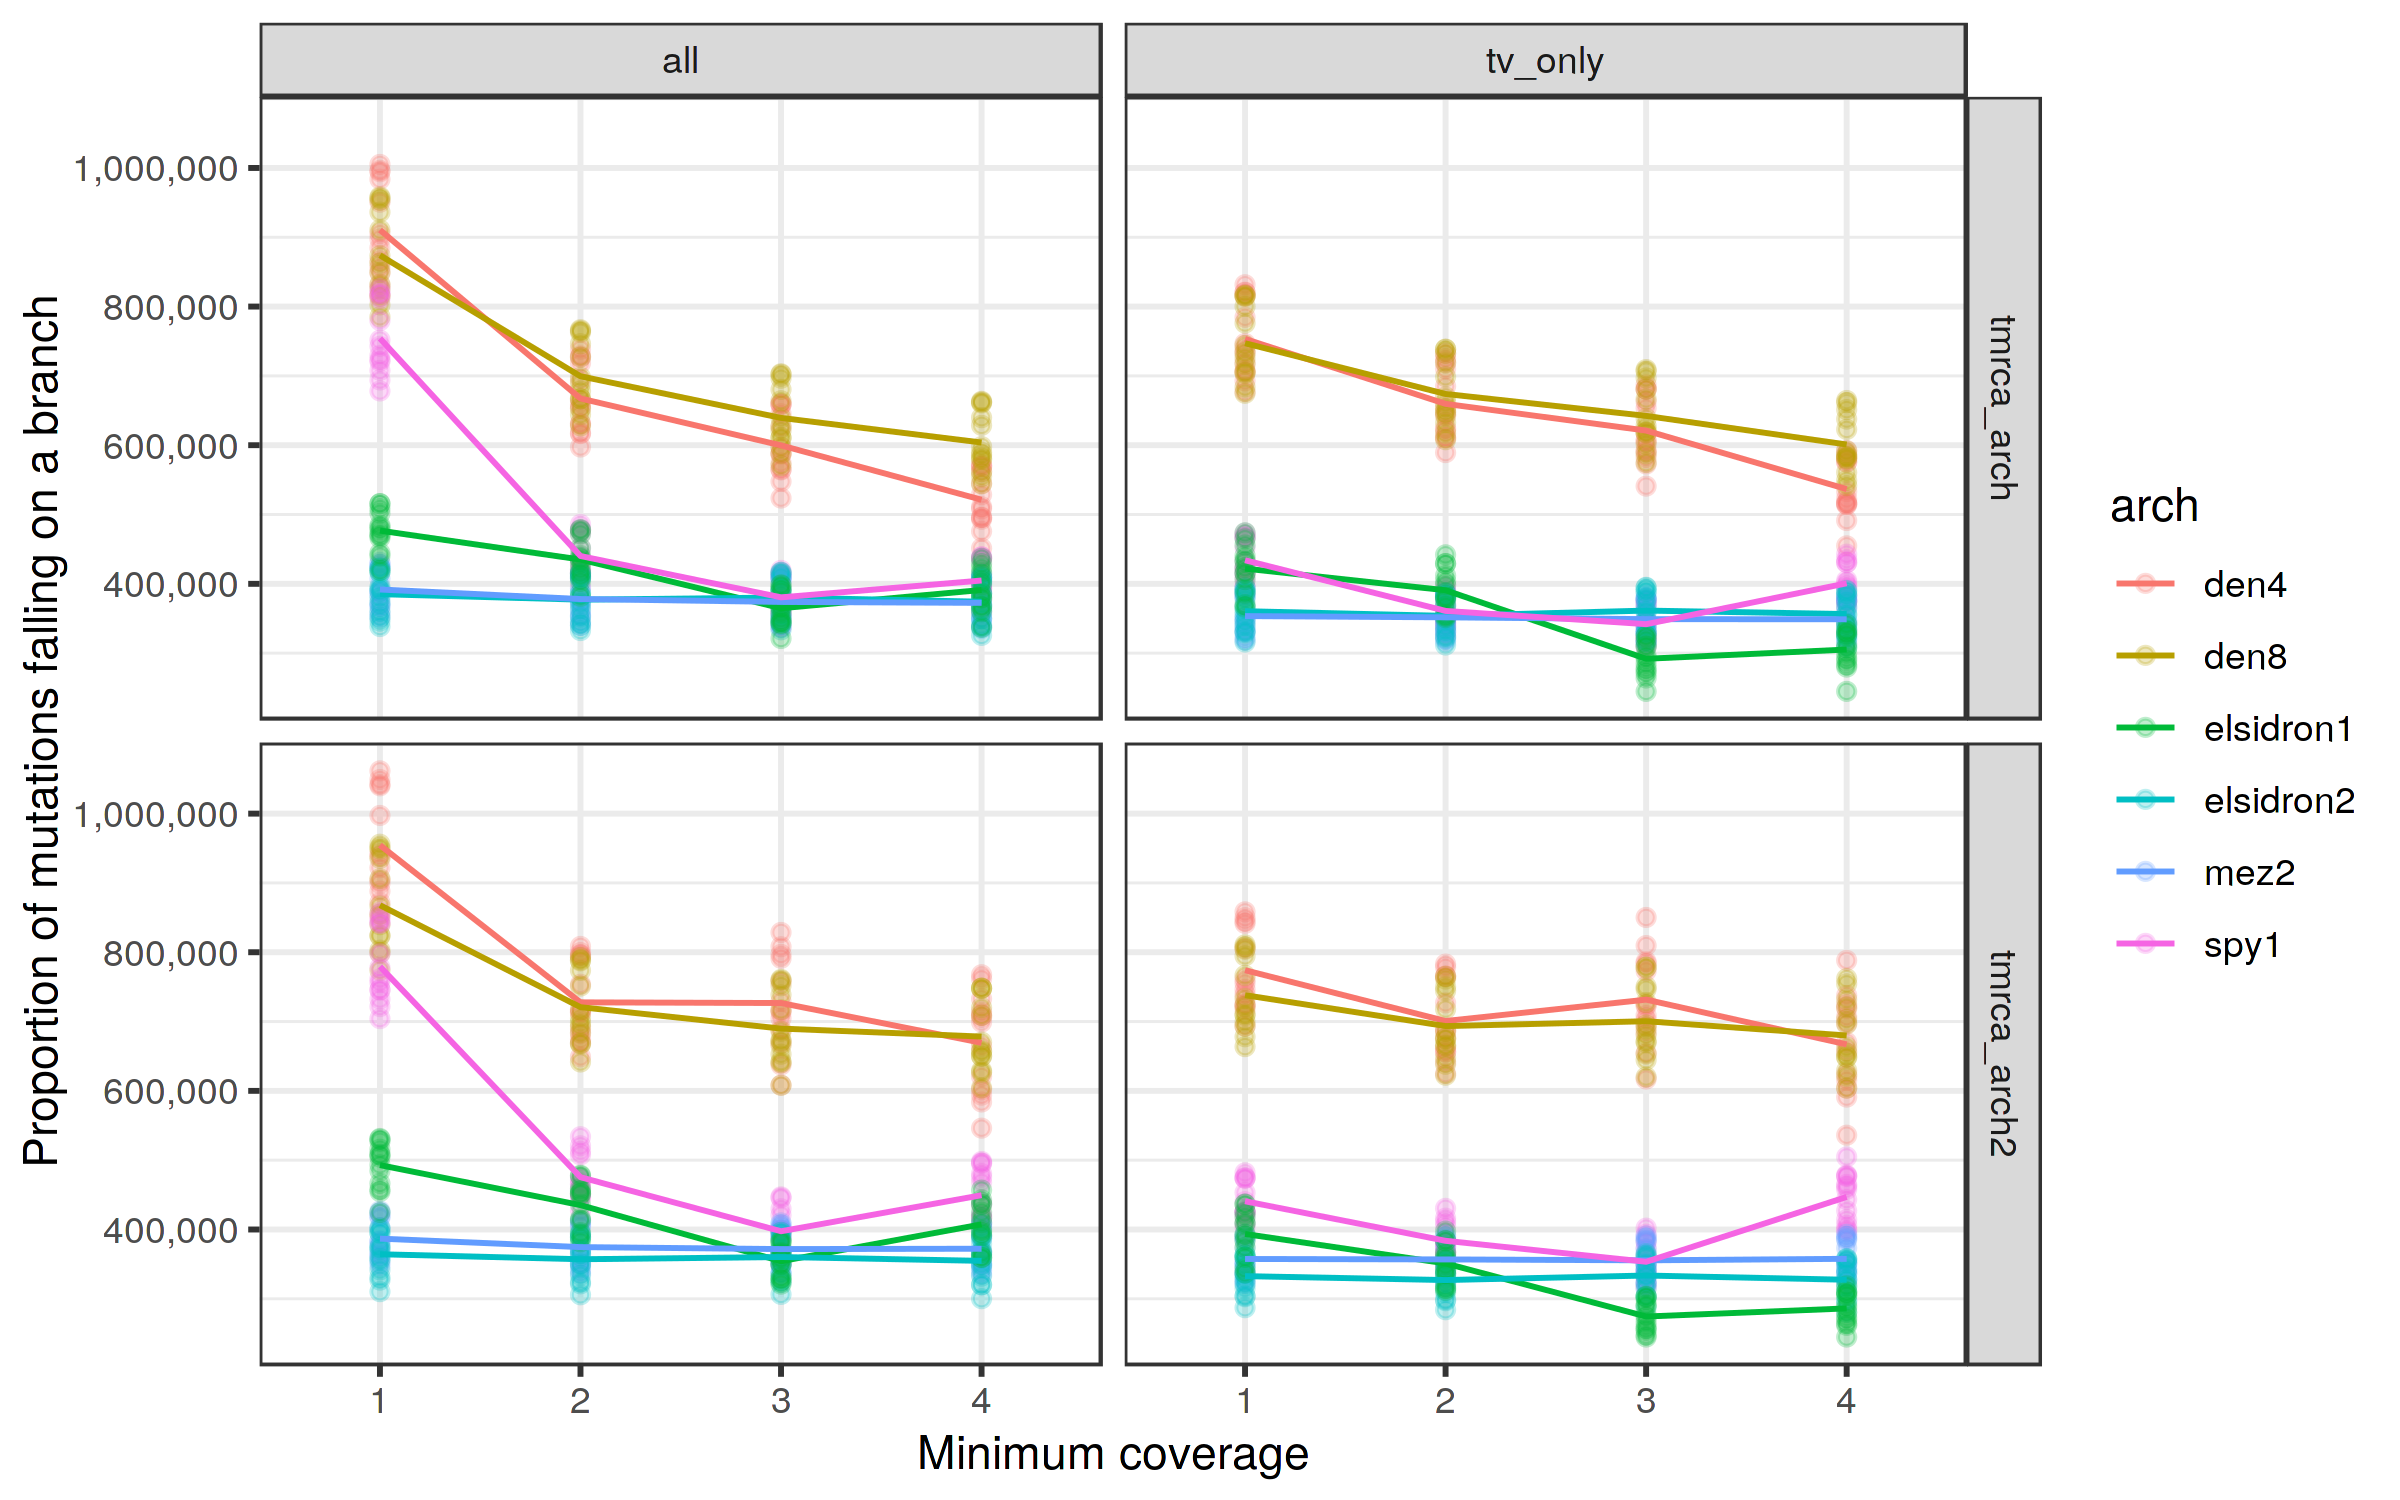

In [201]:
set_dim(8, 5)

tmrca_df %>%
filter(afr == "a00", dp <= 4) %>%
filter(capture == "full" & arch %in% c("den8", "mez2", "den4", "spy1") |
       capture == "lippold" & arch == "elsidron2" |
       capture == "exome" & arch == "elsidron1") %>%
unnest(counts_arch) %>%
mutate(alpha2 = (a + d) / d, tmrca_arch2 = alpha2 * tmrca_f) %>%
select(arch, tmrca_arch, tmrca_arch2, sites, dp) %>%
gather(tmrca, value, -c(arch, sites, dp)) %>%
filter(!is.na(value), !is.infinite(value)) %>% {
ggplot(., aes(as.factor(dp), value, color = arch, group = arch)) +
    geom_point(alpha = 1/4) +
    geom_line(data = group_by(., arch, sites, dp, tmrca) %>% summarise_all(mean), size = 1 / 2) +
    facet_grid(tmrca ~ sites) +
    theme_bw() +
    scale_y_continuous(labels = comma) +
    xlab("Minimum coverage") +
    ylab("Proportion of mutations falling on a branch")
}

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
“Removed 4 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 4 rows containing missing values (geom_point).”

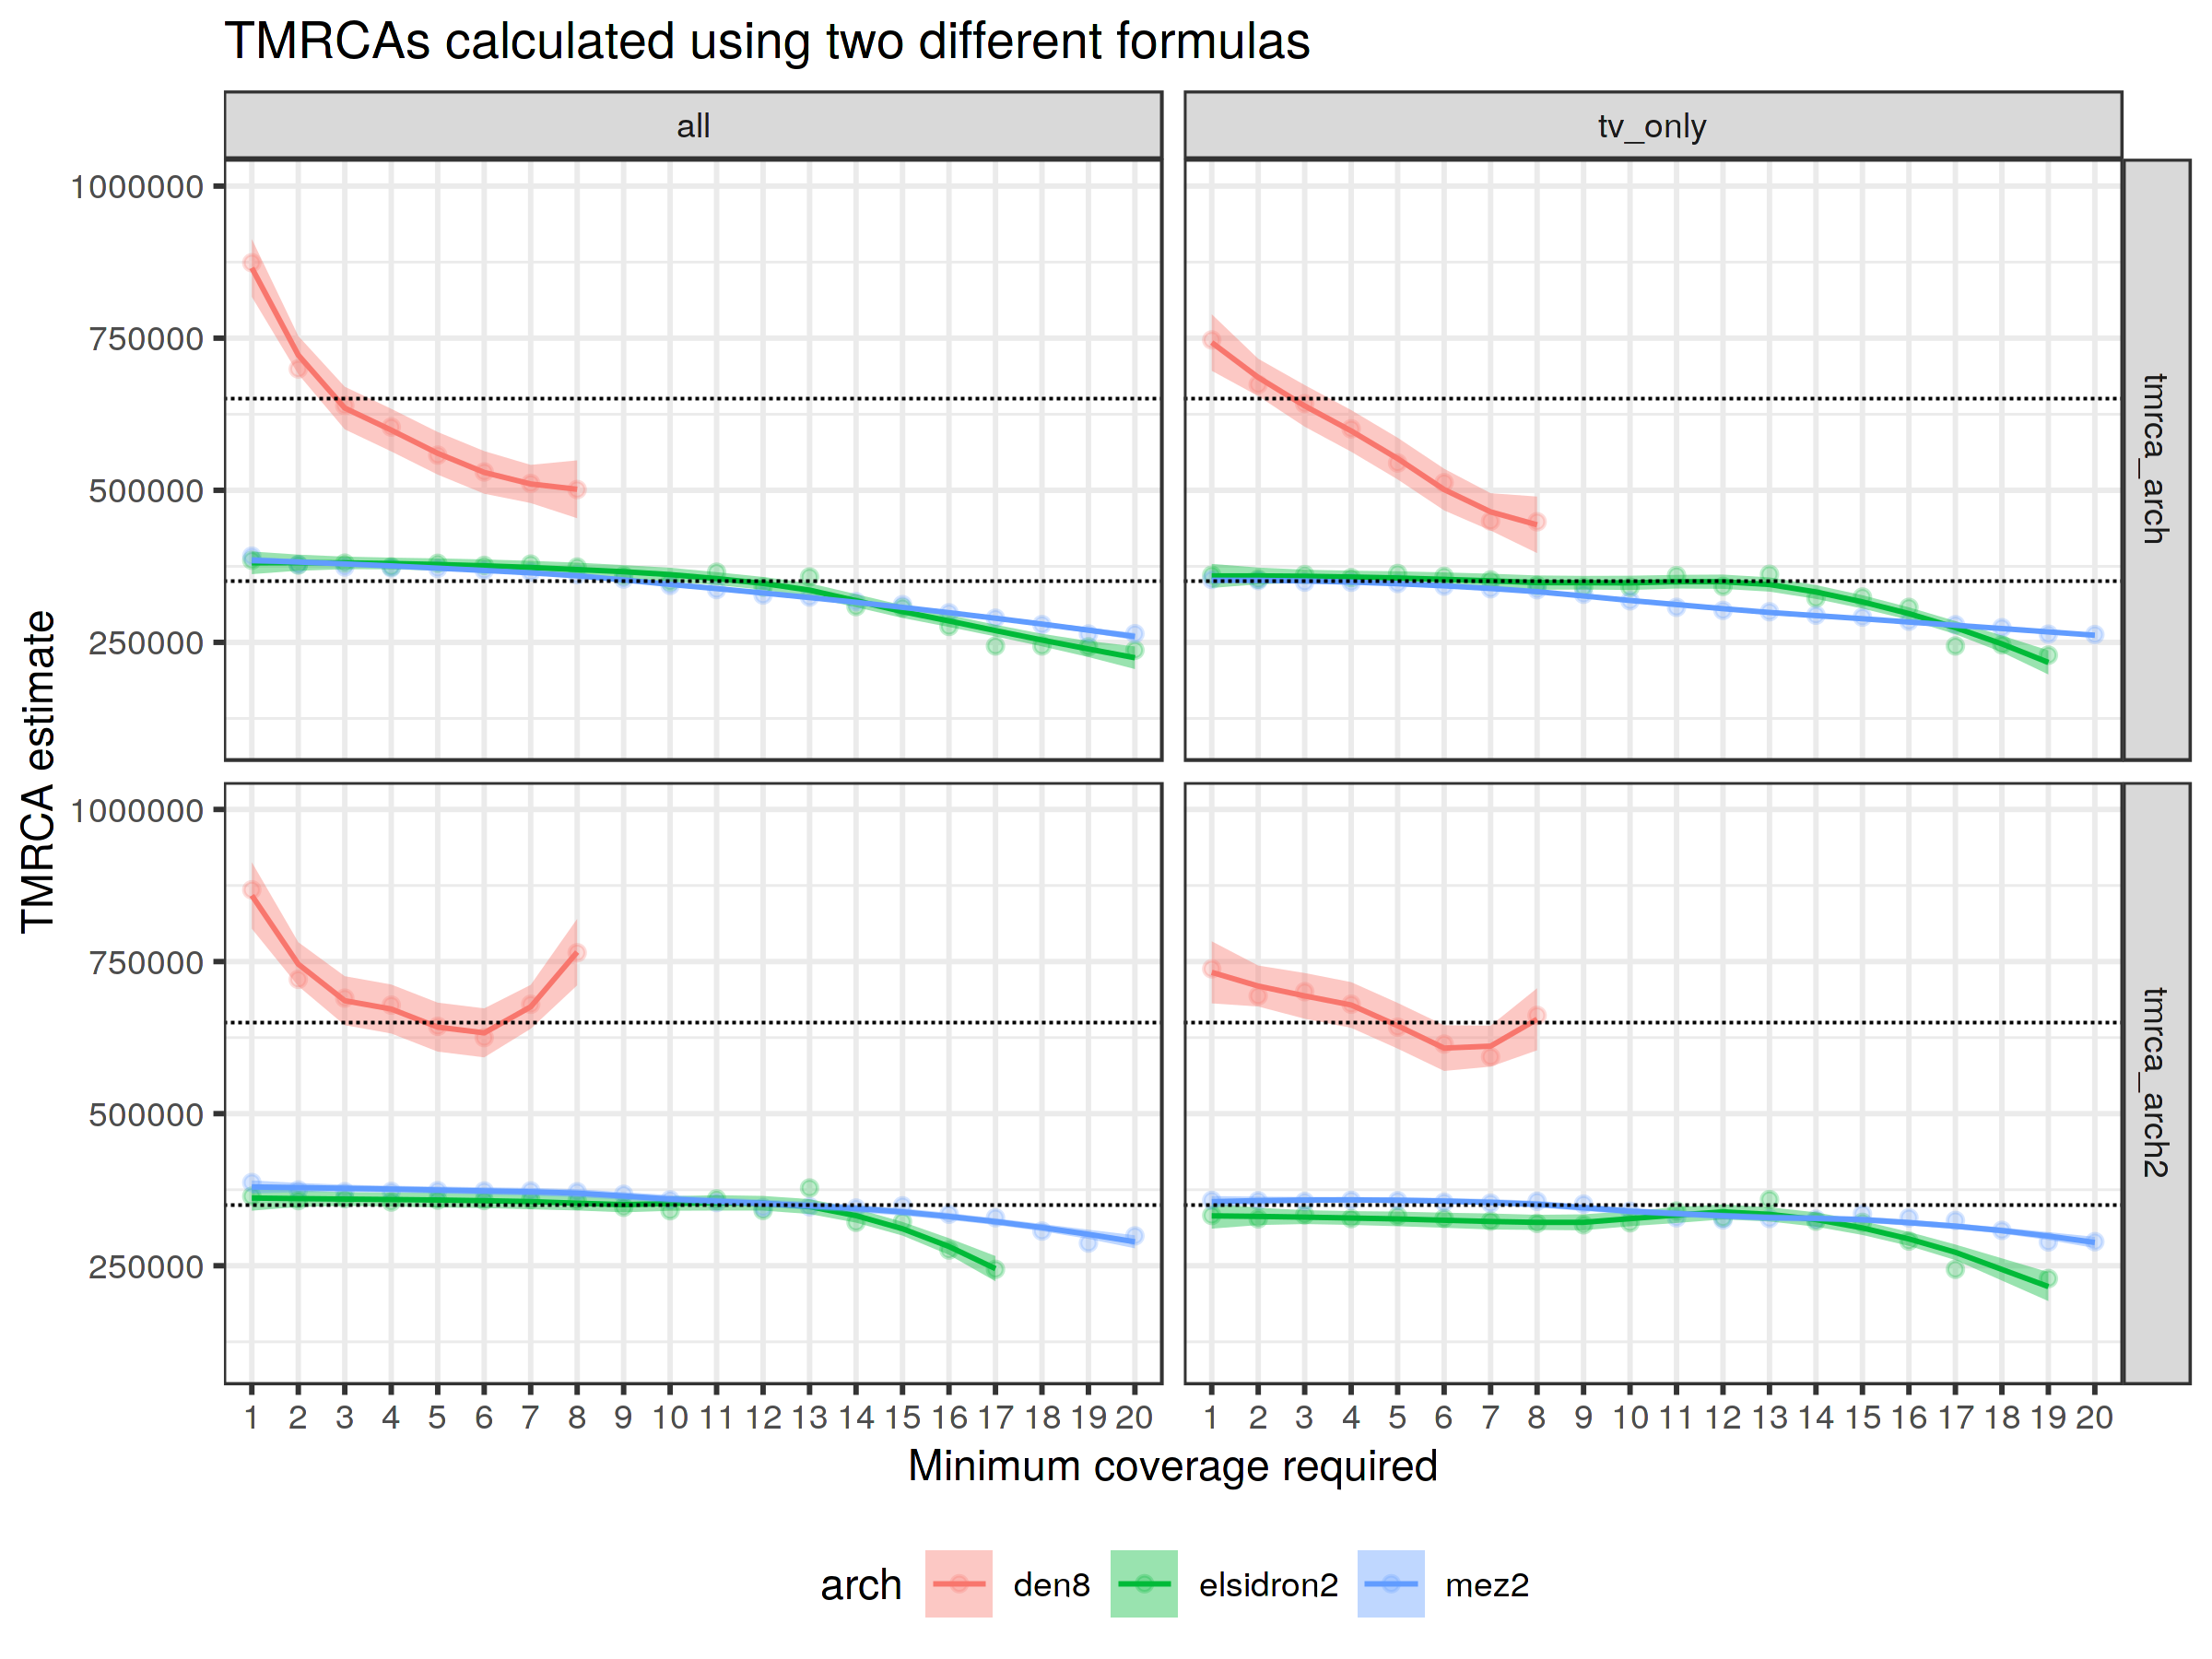

In [25]:
set_dim(8, 6)

tmrca_df %>%
filter(afr == "a00") %>%
filter(capture == "full" & arch %in% c("den8", "mez2") | capture == "lippold" & arch == "elsidron2") %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
unnest(counts_arch) %>%
mutate(alpha2 = (a + d) / d, tmrca_arch2 = alpha2 * tmrca_f) %>%
select(arch, tmrca_arch, tmrca_arch2, sites, dp) %>%
group_by(arch, sites, dp) %>% summarise_all(mean) %>% 
gather(tmrca, value, -c(arch, sites, dp)) %>%
ggplot(aes(dp, value, color = arch)) +
    geom_point(aes(as.factor(dp), value), alpha = 1/4) +
    geom_smooth(aes(fill = arch), size = 0.5) +
    labs(x = "Minimum coverage required", y = "TMRCA estimate") +
    theme_bw() +
    coord_cartesian(y = c(100000, 1000000)) +
    facet_grid(tmrca ~ sites) +
    theme(legend.position = "bottom") +
    ggtitle("TMRCAs calculated using two different formulas") +
    geom_hline(yintercept = c(350000, 650000), linetype = 2, size = 1/3)

# Why do `d` and `e` counts differ so much depending on coverage?

In [92]:
set_dim(6, 3)

tmrca_df %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
filter(afr %in% "a00") %>%
filter(capture == "full" & arch %in% c("den8"), sites == "all") %>%
unnest(counts_arch) %>%
mutate(n_muts = a + b + c + d + e + f) %>% select(-starts_with("tmrca"), -mut_rate) %>%
group_by(arch, afr, dp) %>%
summarise_if(is.numeric, mean) %>%
arrange(dp)

arch afr dp alpha    a          b          c         d         e        
1 den8 a00 1  3.579503 2196.23077 60.0000000 23.769231 860.00000 842.92308
2 den8 a00 2  2.865050 1274.61538 42.4615385 18.923077 653.23077 713.76923
3 den8 a00 3  2.618846  826.76923 32.2307692 13.461538 453.23077 568.38462
4 den8 a00 4  2.473522  510.92308 21.6153846 10.384615 287.61538 406.07692
5 den8 a00 5  2.285260  282.92308  7.8461538  8.692308 173.15385 267.30769
6 den8 a00 6  2.171504  154.15385  3.8461538  2.307692  99.15385 164.23077
7 den8 a00 7  2.094767   78.07692  0.8461538  1.615385  44.23077  98.61538
8 den8 a00 8  2.053920   37.23077  0.0000000  1.230769  18.07692  52.76923
  f           total     n_muts    
1 20423.07692 4922861.4 24406.0000
2  2825.30769 4131217.8  5528.3077
3  1074.15385 3228660.8  2968.2308
4   607.61538 2342632.3  1844.2308
5   347.69231 1572719.0  1087.6154
6   198.07692  974627.1   621.7692
7    95.76923  549088.7   319.1538
8    45.69231  271434.3   155.0000

^^^ note that the `a` length is getting A LOT shorter as we increase the coverage cutoff

d/e ~1 for DP >= 1, as it should be, because there's no reason for them to be different, really

### The following means that the `a` branch is getting increasingly shorter than `e` the higher the required coverage cutoff is

But note that it's the same even for Mez2! Probably not archaic-caused ref bias?!

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


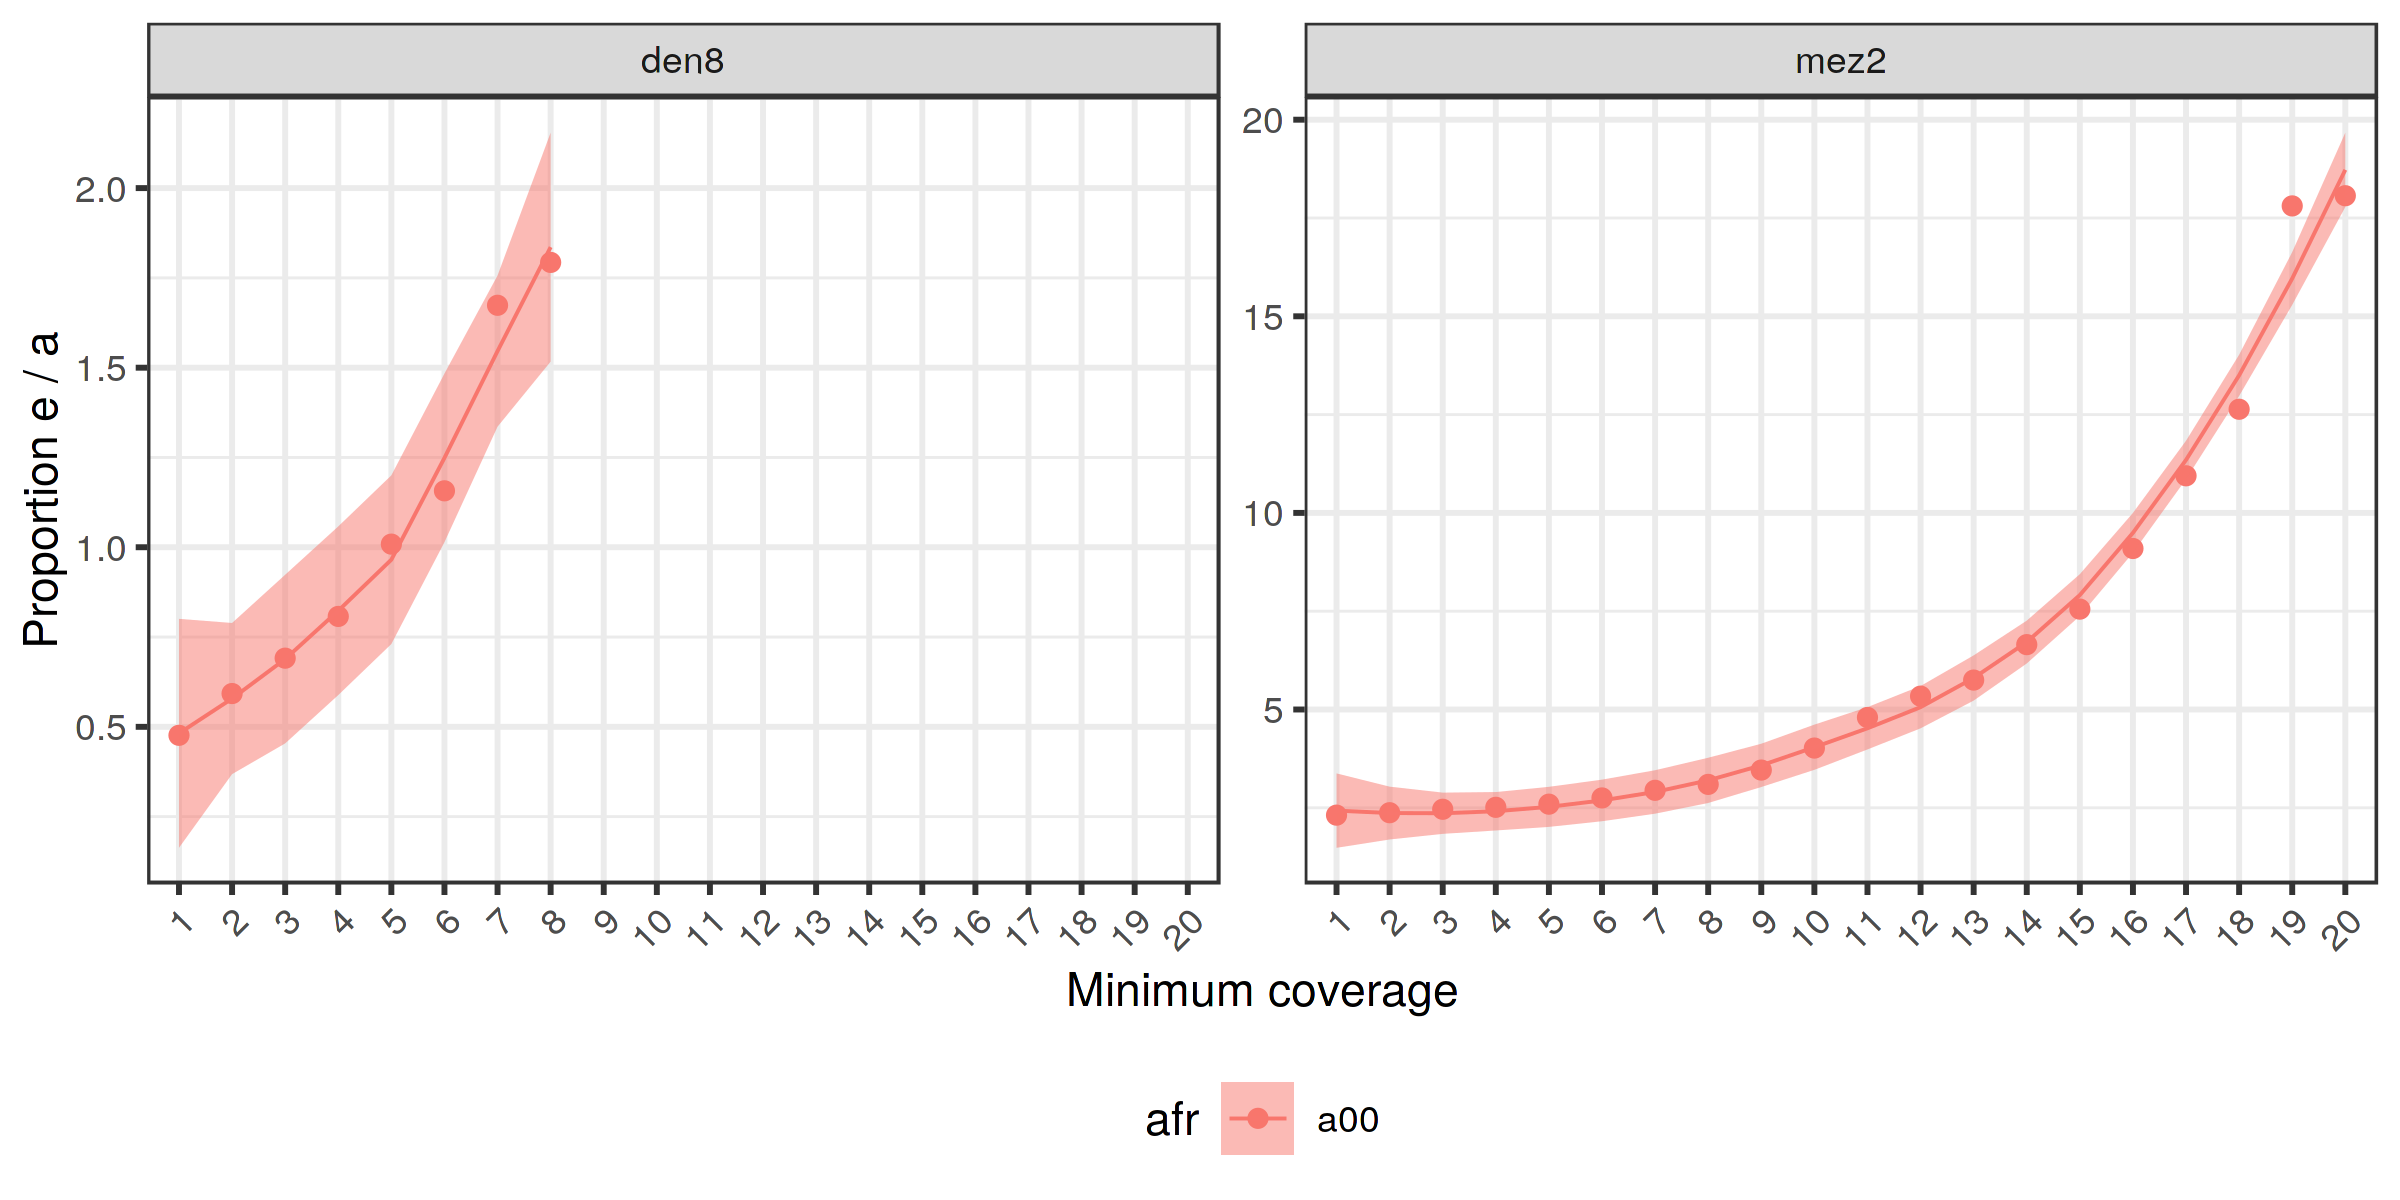

In [63]:
set_dim(8, 4)

tmrca_df %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
filter(sites == "tv_only", capture == "full" & arch %in% c("den8", "mez2") | capture == "lippold" & arch == "asd") %>%
unnest(counts_arch) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
#select(arch, afr, dp, tmrca_arch, alpha, a, b, c, d, e, f, total, n_muts, sites) %>%
#gather(branch, count, -c(arch, afr, dp, alpha, tmrca_arch, total, n_muts, sites)) %>% 
#filter(branch %in% c("d", "e")) %>% 
group_by(arch, afr, dp, sites) %>%
summarise_if(is.numeric, mean) %>%
mutate(prop = e / a) %>% 
ggplot(aes(as.factor(dp), prop, color = afr, fill = afr, group = afr)) +
    geom_point() +
    geom_smooth(size = 1/3, alpha = 1/2) +
    facet_wrap(~ arch, scales = "free_y") +
    theme_bw() + xlab("Minimum coverage") + ylab("Proportion e / a") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

### ... but not the `d` branch... ?

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


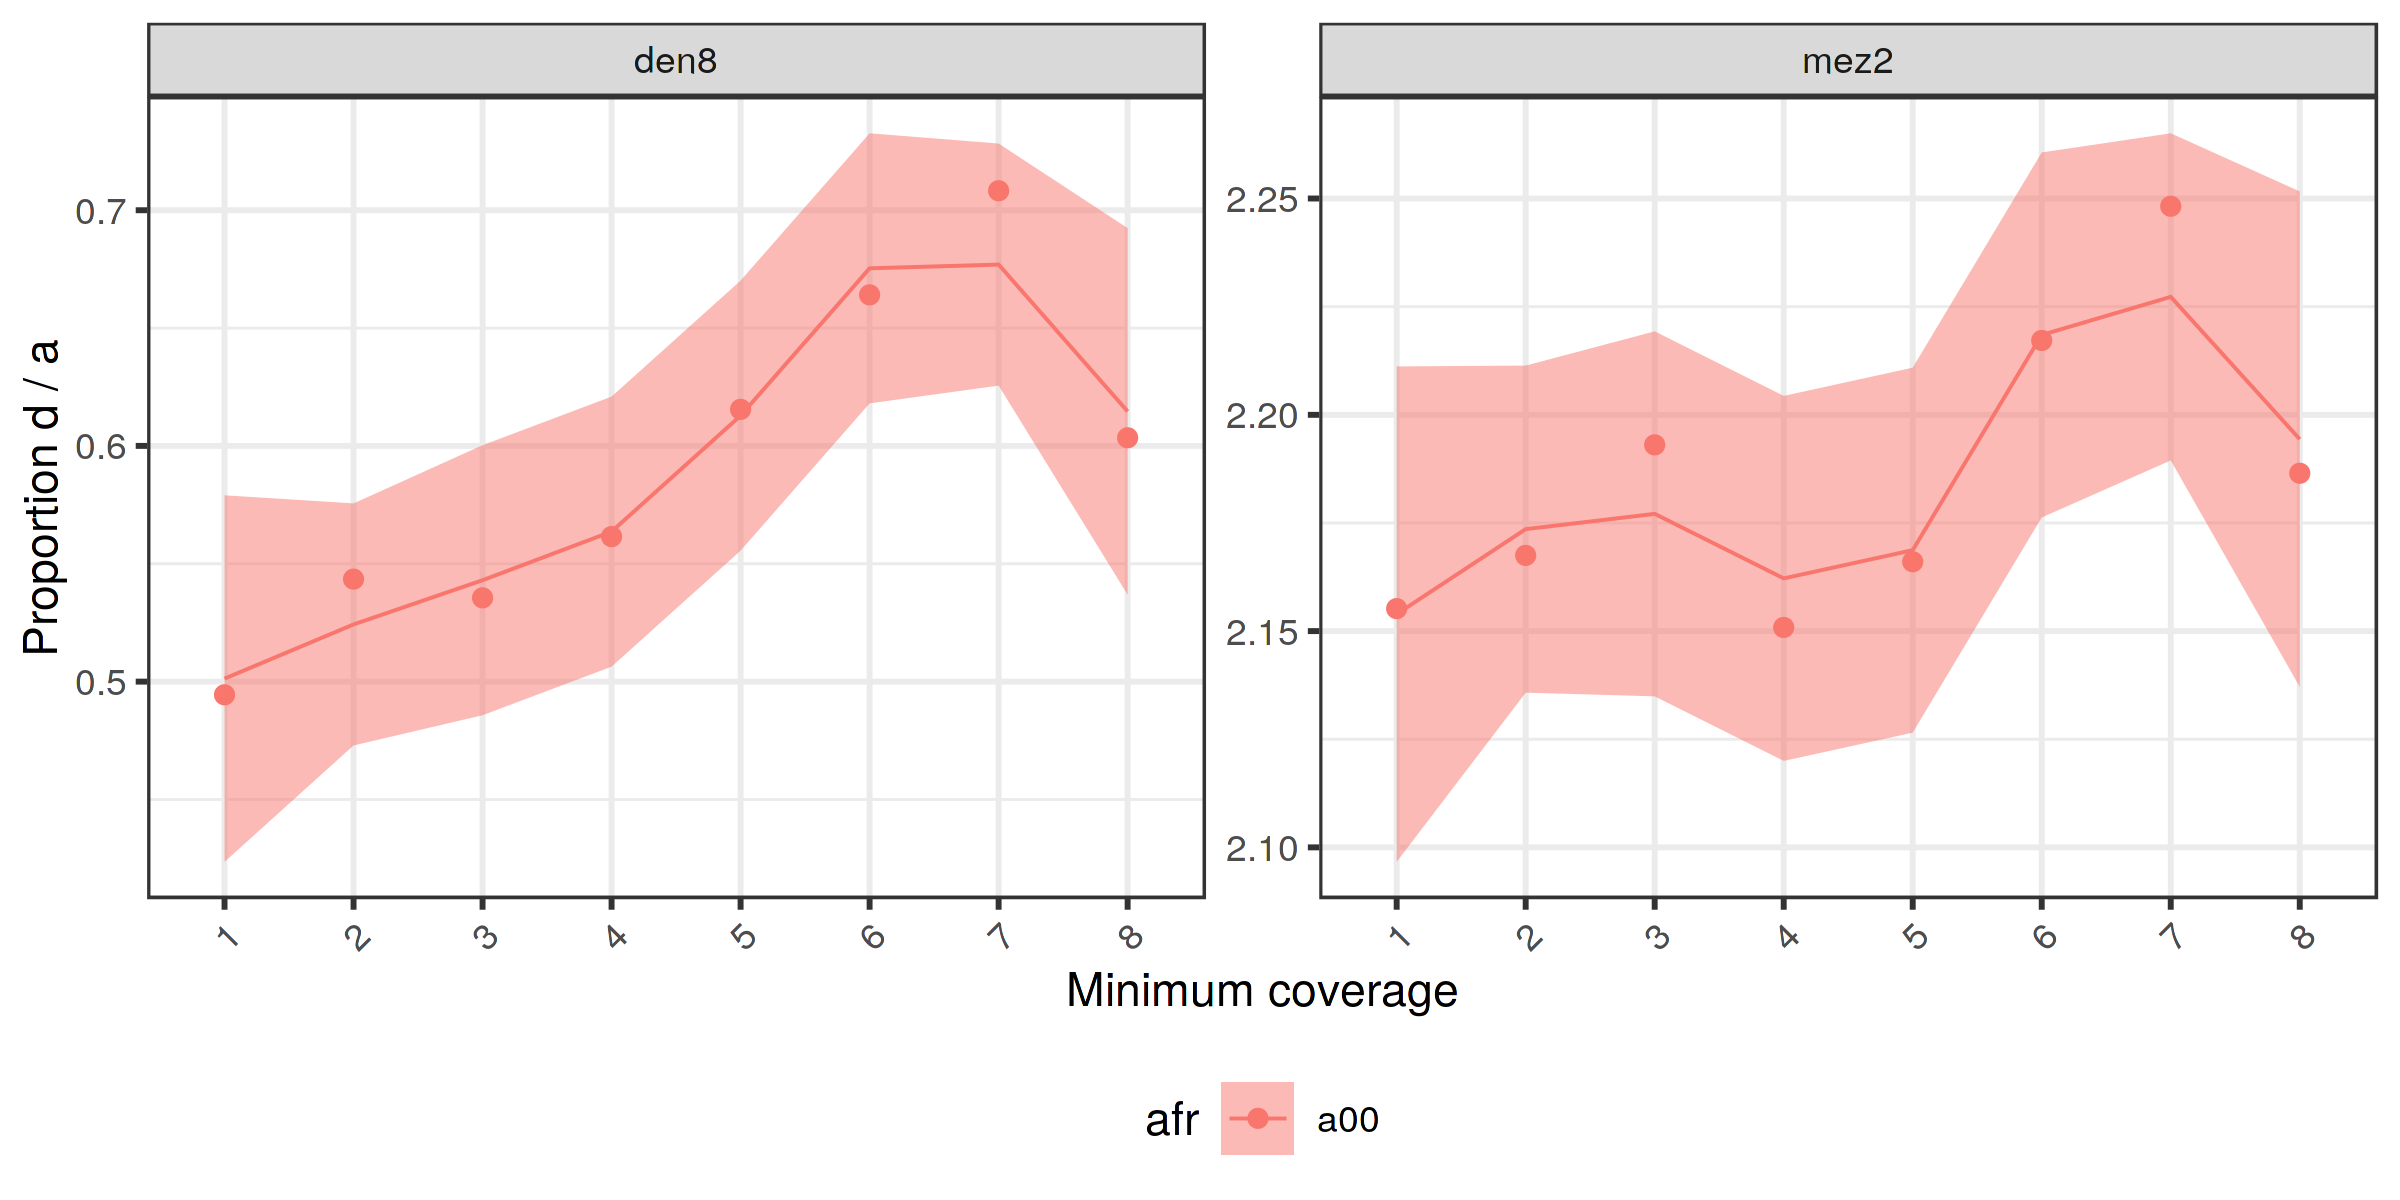

In [91]:
set_dim(8, 4)

tmrca_df %>%
filter(dp < 9, !is.infinite(alpha), !is.nan(alpha)) %>%
filter(sites == "tv_only", capture == "full" & arch %in% c("den8", "mez2") | capture == "lippold" & arch == "asd") %>%
unnest(counts_arch) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
group_by(arch, afr, dp, sites) %>%
summarise_if(is.numeric, mean) %>%
mutate(prop = d / a) %>% 
ggplot(aes(as.factor(dp), prop, color = afr, fill = afr, group = afr)) +
    geom_point() +
    geom_smooth(size = 1/3, alpha = 1/2) +
    facet_wrap(~ arch, scales = "free_y") +
    theme_bw() + xlab("Minimum coverage") + ylab("Proportion d / a") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

### What about `d` vs `e`? This proportion should be ~1.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


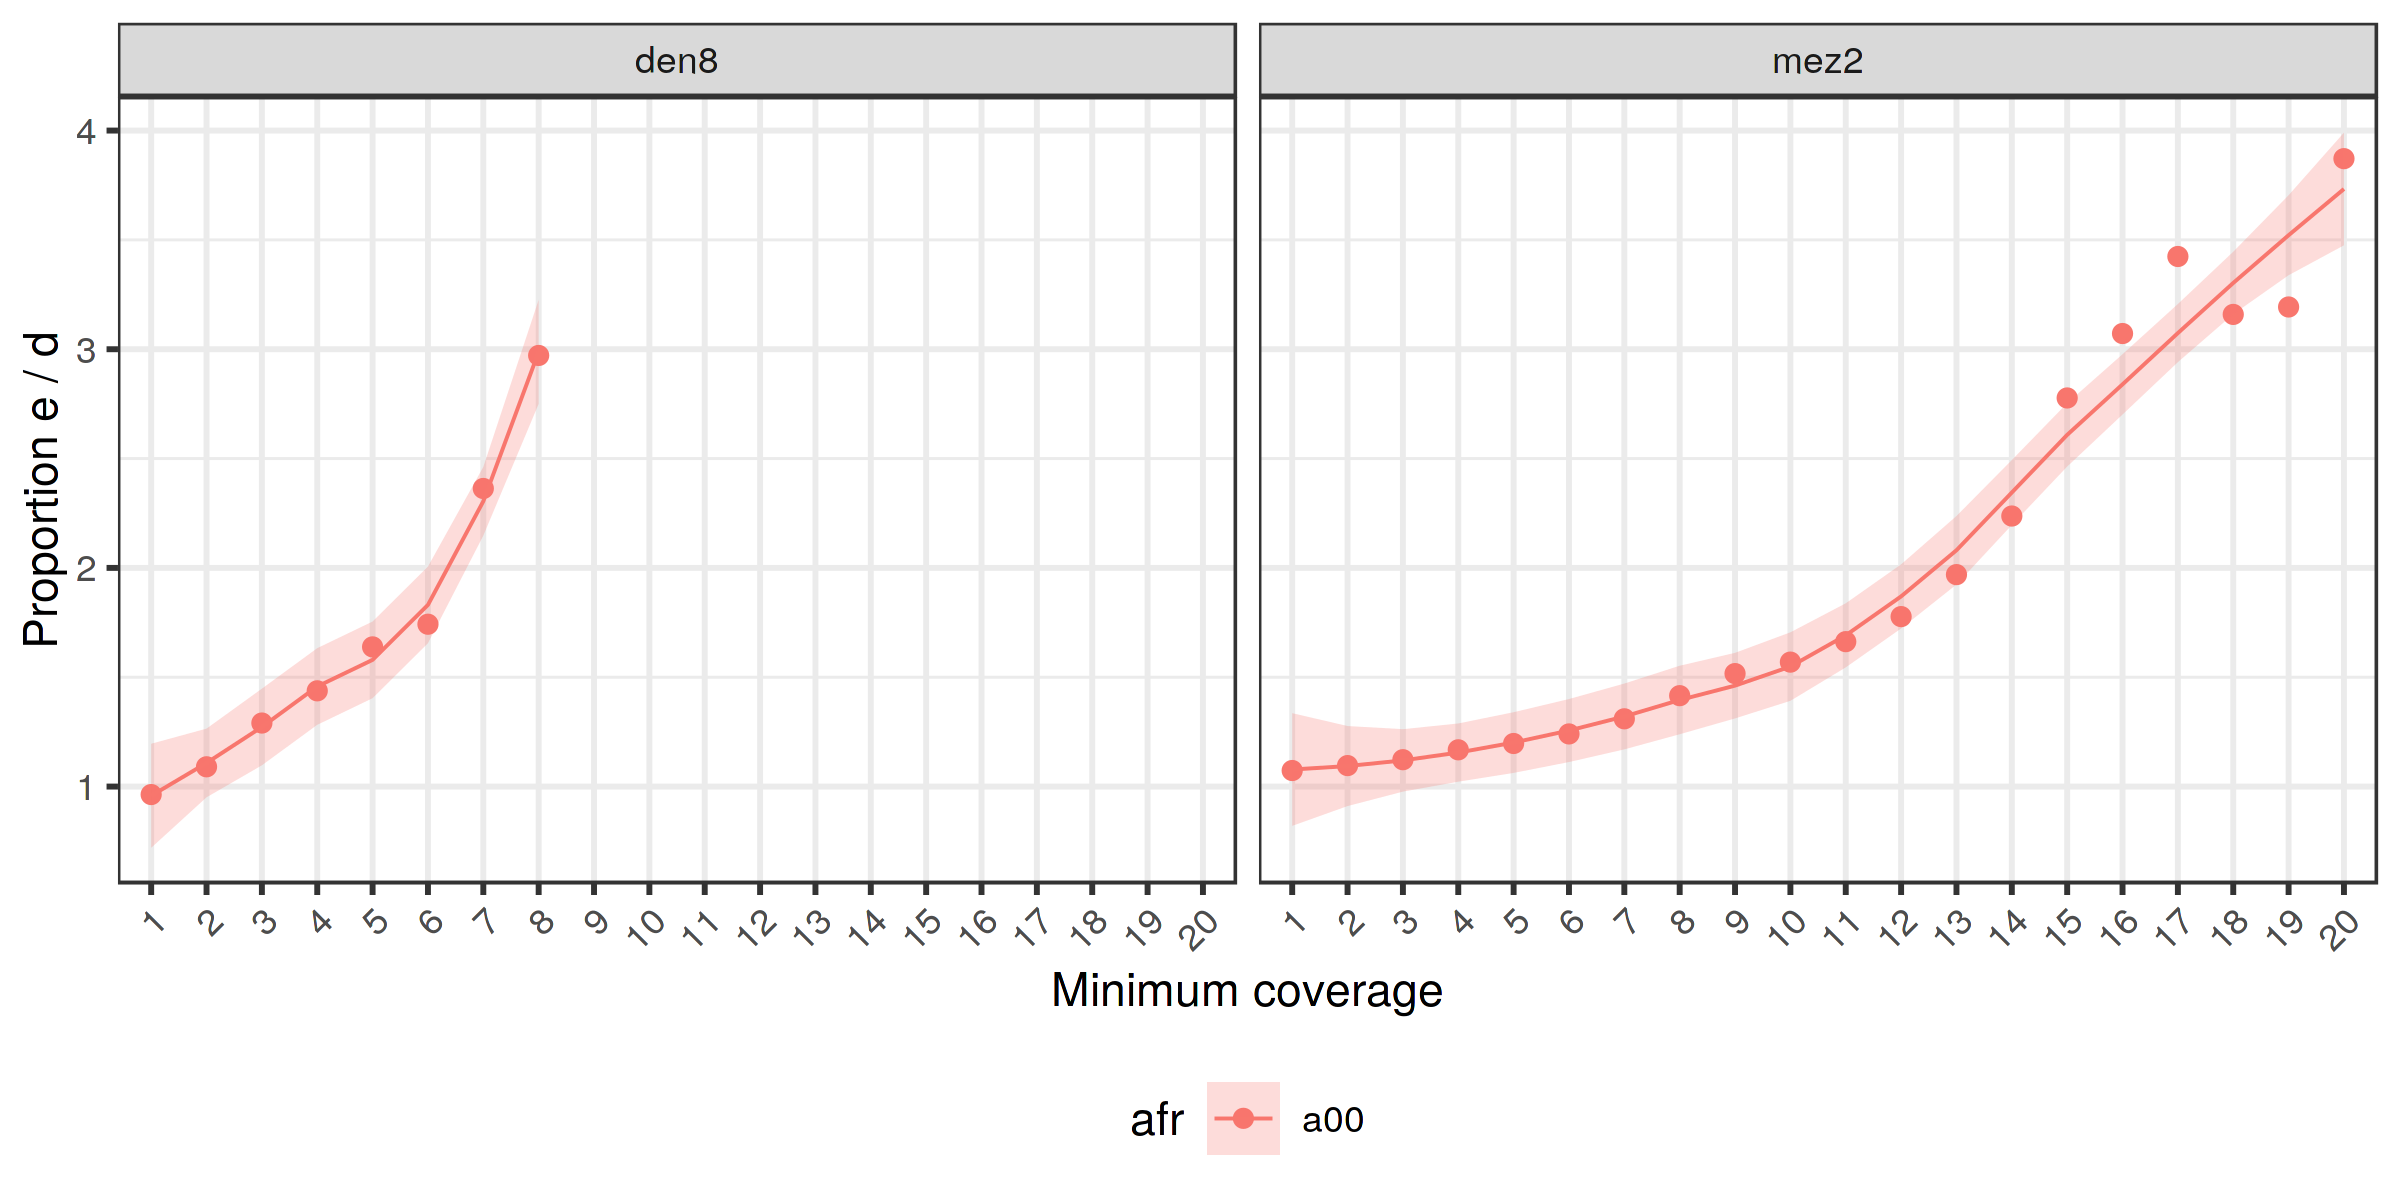

In [96]:
set_dim(8, 4)

tmrca_df %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
filter(sites == "tv_only", capture == "full" & arch %in% c("den8", "mez2")) %>%
unnest(counts_arch) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
group_by(arch, afr, dp, sites) %>%
summarise_if(is.numeric, mean) %>%
mutate(prop = e / d) %>% 
ggplot(aes(as.factor(dp), prop, color = afr, fill = afr, group = afr)) +
    geom_point() +
    geom_smooth(size = 1/3, alpha = 1/4) +
    facet_grid(. ~ arch) +
    theme_bw() + xlab("Minimum coverage") + ylab("Proportion e / d") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


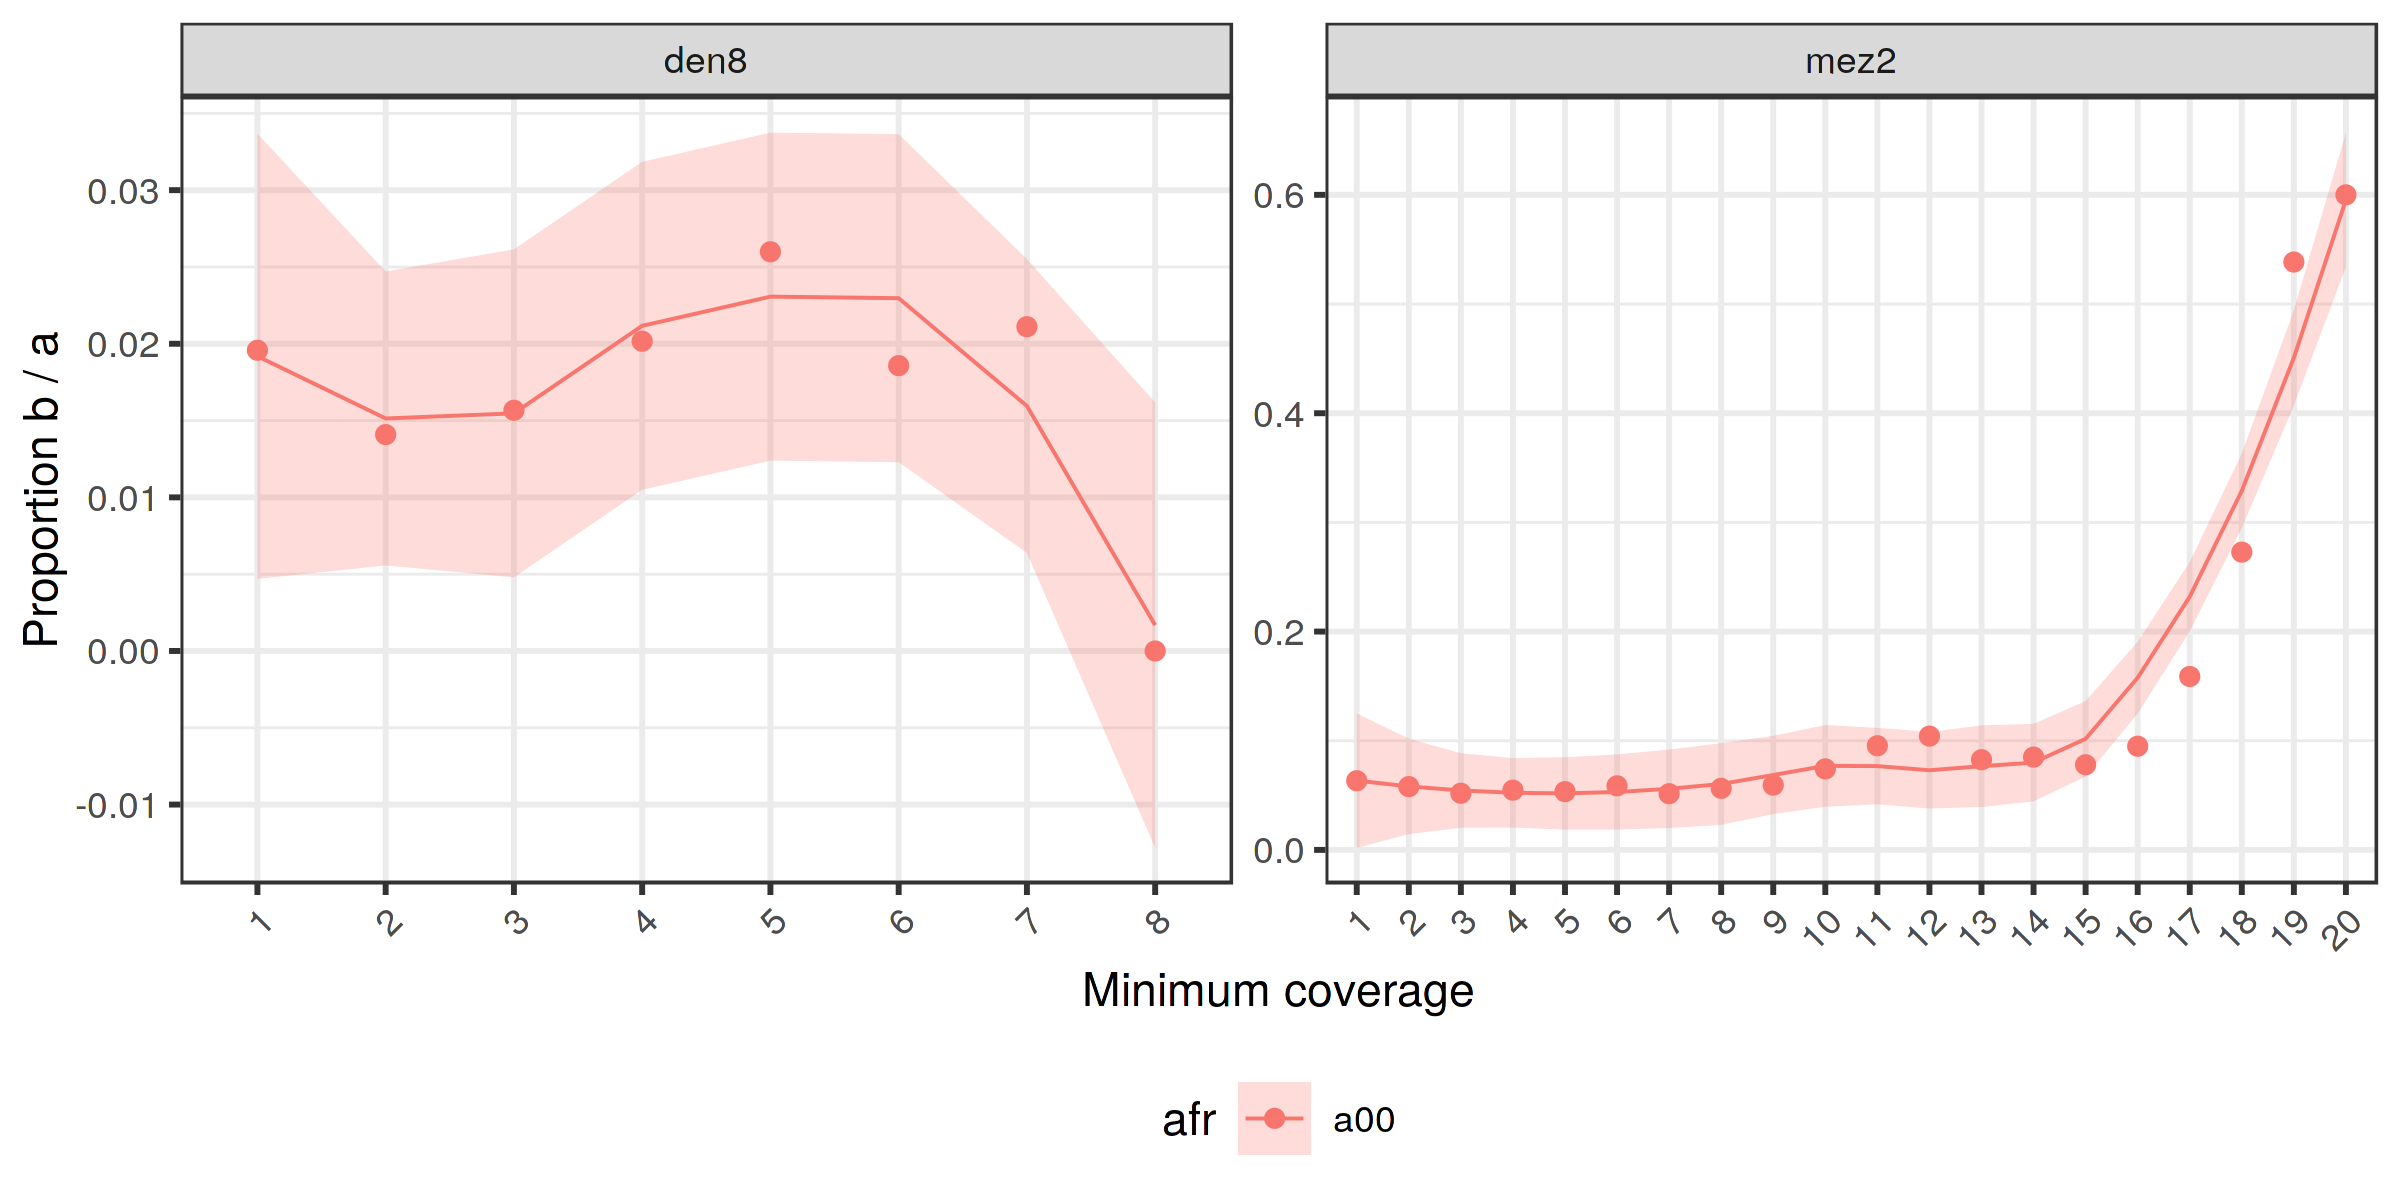

In [85]:
set_dim(8, 4)

tmrca_df %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
filter(sites == "tv_only", capture == "full" & arch %in% c("den8", "mez2")) %>%
unnest(counts_arch) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
group_by(arch, afr, dp, sites) %>%
summarise_if(is.numeric, mean) %>%
mutate(prop = b / a) %>% 
ggplot(aes(as.factor(dp), prop, color = afr, fill = afr, group = afr)) +
    geom_point() +
    geom_smooth(size = 1/3, alpha = 1/4) +
    facet_wrap(~ arch, scales = "free") +
    theme_bw() + xlab("Minimum coverage") + ylab("Proportion b / a") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


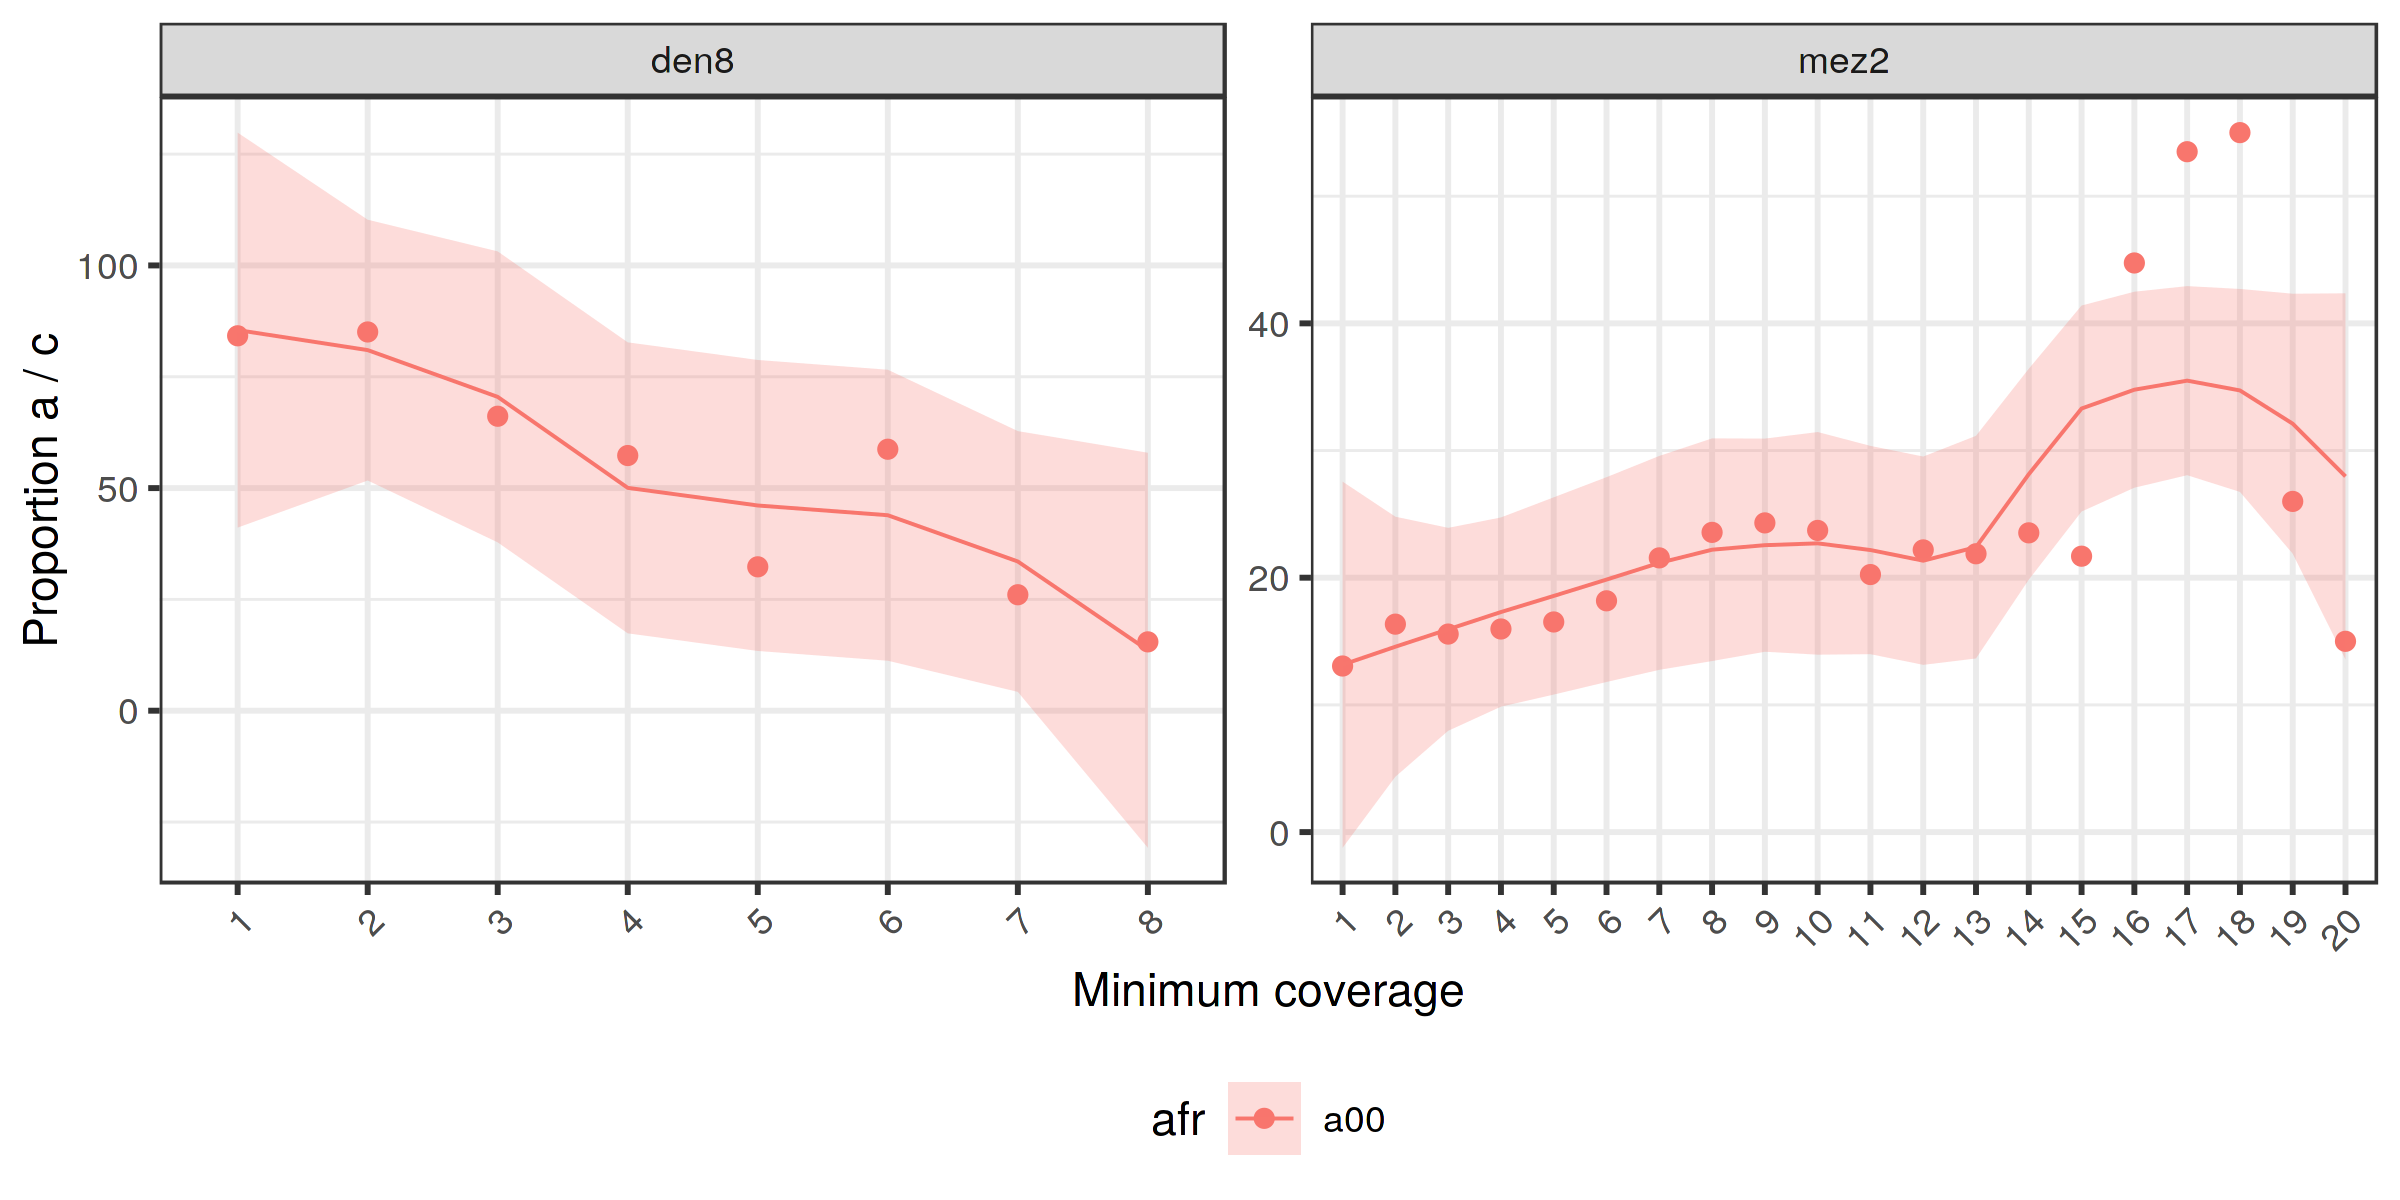

In [87]:
set_dim(8, 4)

tmrca_df %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
filter(sites == "tv_only", capture == "full" & arch %in% c("den8", "mez2")) %>%
unnest(counts_arch) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
group_by(arch, afr, dp, sites) %>%
summarise_if(is.numeric, mean) %>%
mutate(prop = a / c) %>% 
ggplot(aes(as.factor(dp), prop, color = afr, fill = afr, group = afr)) +
    geom_point() +
    geom_smooth(size = 1/3, alpha = 1/4) +
    facet_wrap(~ arch, scales = "free") +
    theme_bw() + xlab("Minimum coverage") + ylab("Proportion a / c") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

In [22]:
tmrca_df %>% filter(arch == "den4", capture == "full", dp == 3, sites == "all") %>%
unnest(counts_arch) %>% select(-starts_with("tmrca"), -counts_afr) %>% mutate(c / b)

arch afr ref           alpha    mut_rate     dp sites capture tafr a   b  c
1  den4 a00 S_BedouinB_1  2.404494 7.604210e-10 3  all   full    all  250 12 6
2  den4 a00 S_Turkish_1   2.509091 7.564185e-10 3  all   full    all  249 11 4
3  den4 a00 S_French_1    2.485380 6.488335e-10 3  all   full    all  254 10 6
4  den4 a00 S_Burmese_1   2.466276 6.842809e-10 3  all   full    all  250 11 5
5  den4 a00 S_Thai_1      2.479042 6.530264e-10 3  all   full    all  247 11 5
6  den4 a00 S_Finnish_2   2.404494 7.106824e-10 3  all   full    all  250 11 5
7  den4 a00 S_Sardinian_1 2.379888 7.854412e-10 3  all   full    all  247 11 6
8  den4 a00 S_Han_2       2.483680 6.506438e-10 3  all   full    all  250 11 9
9  den4 a00 S_Dai_2       2.460870 7.213219e-10 3  all   full    all  252 10 5
10 den4 a00 S_Punjabi_1   2.462428 6.660889e-10 3  all   full    all  253 11 6
11 den4 a00 S_Saami_2     2.423729 7.497635e-10 3  all   full    all  252 10 4
12 den4 a00 S_Papuan_2    2.454023 7.302752e-10 3  all   full    all  253 11 6
13 den4 a00 S_Karitiana_1 2.510574 7.751364e-10 3  all   full    all  250 10 6
   d   e   f   total   c/b      
1  139 217 412 1364190 0.5000000
2  114 216 418 1364575 0.3636364
3  128 214 414 1367323 0.6000000
4  126 215 410 1367286 0.4545455
5  121 213 407 1358883 0.4545455
6  138 218 405 1369075 0.4545455
7  140 218 411 1360566 0.5454545
8  118 219 414 1372231 0.8181818
9  129 216 409 1365562 0.5000000
10 124 222 414 1371732 0.5454545
11 135 219 416 1361040 0.4000000
12 130 218 414 1367793 0.5454545
13 115 216 409 1364258 0.6000000

In [21]:
tmrca_df %>% filter(arch == "den8", capture == "full", dp == 3, sites == "all") %>%
unnest(counts_arch) %>% select(-starts_with("tmrca"), -counts_afr) %>% mutate(c / b)

arch afr ref           alpha    mut_rate     dp sites capture tafr a   b  c 
1  den8 a00 S_BedouinB_1  2.621939 7.604210e-10 3  all   full    all  828 33 13
2  den8 a00 S_Turkish_1   2.669706 7.564185e-10 3  all   full    all  824 33 10
3  den8 a00 S_French_1    2.627586 6.488335e-10 3  all   full    all  826 30 14
4  den8 a00 S_Burmese_1   2.616813 6.842809e-10 3  all   full    all  827 32 14
5  den8 a00 S_Thai_1      2.642502 6.530264e-10 3  all   full    all  827 33 15
6  den8 a00 S_Finnish_2   2.612027 7.106824e-10 3  all   full    all  831 32 16
7  den8 a00 S_Sardinian_1 2.593449 7.854412e-10 3  all   full    all  827 31 13
8  den8 a00 S_Han_2       2.646245 6.506438e-10 3  all   full    all  833 33 15
9  den8 a00 S_Dai_2       2.589200 7.213219e-10 3  all   full    all  824 32 14
10 den8 a00 S_Punjabi_1   2.596098 6.660889e-10 3  all   full    all  818 33 12
11 den8 a00 S_Saami_2     2.615907 7.497635e-10 3  all   full    all  833 32 10
12 den8 a00 S_Papuan_2    2.596542 7.302752e-10 3  all   full    all  831 33 16
13 den8 a00 S_Karitiana_1 2.616979 7.751364e-10 3  all   full    all  819 32 13
   d   e   f    total   c/b      
1  455 566 1073 3225246 0.3939394
2  425 562 1078 3225531 0.3030303
3  450 565 1072 3232027 0.4666667
4  453 570 1074 3233146 0.4375000
5  445 562 1062 3211527 0.4545455
6  461 570 1074 3236612 0.5000000
7  469 569 1071 3218512 0.4193548
8  447 565 1078 3244002 0.4545455
9  465 572 1073 3224260 0.4375000
10 450 575 1080 3243240 0.3636364
11 463 568 1072 3217665 0.3125000
12 466 575 1080 3235240 0.4848485
13 443 570 1077 3225583 0.4062500

In [23]:
tmrca_df %>% filter(arch == "spy1", capture == "full", dp == 3, sites == "all") %>%
unnest(counts_arch) %>% select(-starts_with("tmrca"), -counts_afr) %>% mutate(c / b)

arch afr ref           alpha    mut_rate     dp sites capture tafr a  b c d 
1  spy1 a00 S_BedouinB_1  1.573770 7.604210e-10 3  all   full    all  35 8 0 57
2  spy1 a00 S_Turkish_1   1.556522 7.564185e-10 3  all   full    all  32 7 0 46
3  spy1 a00 S_French_1    1.566372 6.488335e-10 3  all   full    all  32 7 0 47
4  spy1 a00 S_Burmese_1   1.549618 6.842809e-10 3  all   full    all  36 8 1 63
5  spy1 a00 S_Thai_1      1.552846 6.530264e-10 3  all   full    all  34 8 0 55
6  spy1 a00 S_Finnish_2   1.564516 7.106824e-10 3  all   full    all  35 8 0 56
7  spy1 a00 S_Sardinian_1 1.536585 7.854412e-10 3  all   full    all  33 8 0 56
8  spy1 a00 S_Han_2       1.542636 6.506438e-10 3  all   full    all  35 8 3 60
9  spy1 a00 S_Dai_2       1.548387 7.213219e-10 3  all   full    all  34 7 0 55
10 spy1 a00 S_Punjabi_1   1.600000 6.660889e-10 3  all   full    all  36 8 0 51
11 spy1 a00 S_Saami_2     1.555556 7.497635e-10 3  all   full    all  35 8 0 59
12 spy1 a00 S_Papuan_2    1.566667 7.302752e-10 3  all   full    all  34 7 0 51
13 spy1 a00 S_Karitiana_1 1.544000 7.751364e-10 3  all   full    all  34 6 2 57
   e  f   total  c/b      
1  65 616 497824 0.0000000
2  69 616 497340 0.0000000
3  66 613 499039 0.0000000
4  68 610 498955 0.1250000
5  68 611 496007 0.0000000
6  68 615 499686 0.0000000
7  67 613 497029 0.0000000
8  69 616 500841 0.3750000
9  69 618 497065 0.0000000
10 69 614 501714 0.0000000
11 67 616 496743 0.0000000
12 69 619 500008 0.0000000
13 68 604 498882 0.3333333

In [24]:
tmrca_df %>% filter(arch == "mez2", capture == "full", dp == 3, sites == "all") %>%
unnest(counts_arch) %>% select(-starts_with("tmrca"), -counts_afr) %>% mutate(c / b)

arch afr ref           alpha    mut_rate     dp sites capture tafr a   b  c 
1  mez2 a00 S_BedouinB_1  1.542349 7.604210e-10 3  all   full    all  381 36 19
2  mez2 a00 S_Turkish_1   1.528622 7.564185e-10 3  all   full    all  374 36 19
3  mez2 a00 S_French_1    1.529537 6.488335e-10 3  all   full    all  372 34 21
4  mez2 a00 S_Burmese_1   1.531073 6.842809e-10 3  all   full    all  376 36 21
5  mez2 a00 S_Thai_1      1.545716 6.530264e-10 3  all   full    all  379 36 23
6  mez2 a00 S_Finnish_2   1.519137 7.106824e-10 3  all   full    all  373 33 25
7  mez2 a00 S_Sardinian_1 1.532486 7.854412e-10 3  all   full    all  377 33 19
8  mez2 a00 S_Han_2       1.535032 6.506438e-10 3  all   full    all  378 36 21
9  mez2 a00 S_Dai_2       1.528090 7.213219e-10 3  all   full    all  376 35 23
10 mez2 a00 S_Punjabi_1   1.538136 6.660889e-10 3  all   full    all  381 36 20
11 mez2 a00 S_Saami_2     1.532303 7.497635e-10 3  all   full    all  379 34 19
12 mez2 a00 S_Papuan_2    1.526169 7.302752e-10 3  all   full    all  377 36 22
13 mez2 a00 S_Karitiana_1 1.518519 7.751364e-10 3  all   full    all  371 36 19
   d   e   f   total   c/b      
1  716 689 939 4460616 0.5277778
2  722 693 943 4458788 0.5277778
3  715 690 937 4472209 0.6176471
4  717 699 934 4466790 0.5833333
5  700 689 938 4439978 0.6388889
6  737 700 938 4474807 0.7575758
7  717 699 937 4450263 0.5757576
8  711 702 943 4485759 0.5833333
9  728 696 938 4456967 0.6571429
10 717 699 943 4485536 0.5555556
11 728 696 944 4446889 0.5588235
12 732 701 937 4475216 0.6111111
13 730 701 935 4462258 0.5277778

### A00 - both `a` and `d` relatively stable across coverage, but `e` is increasing

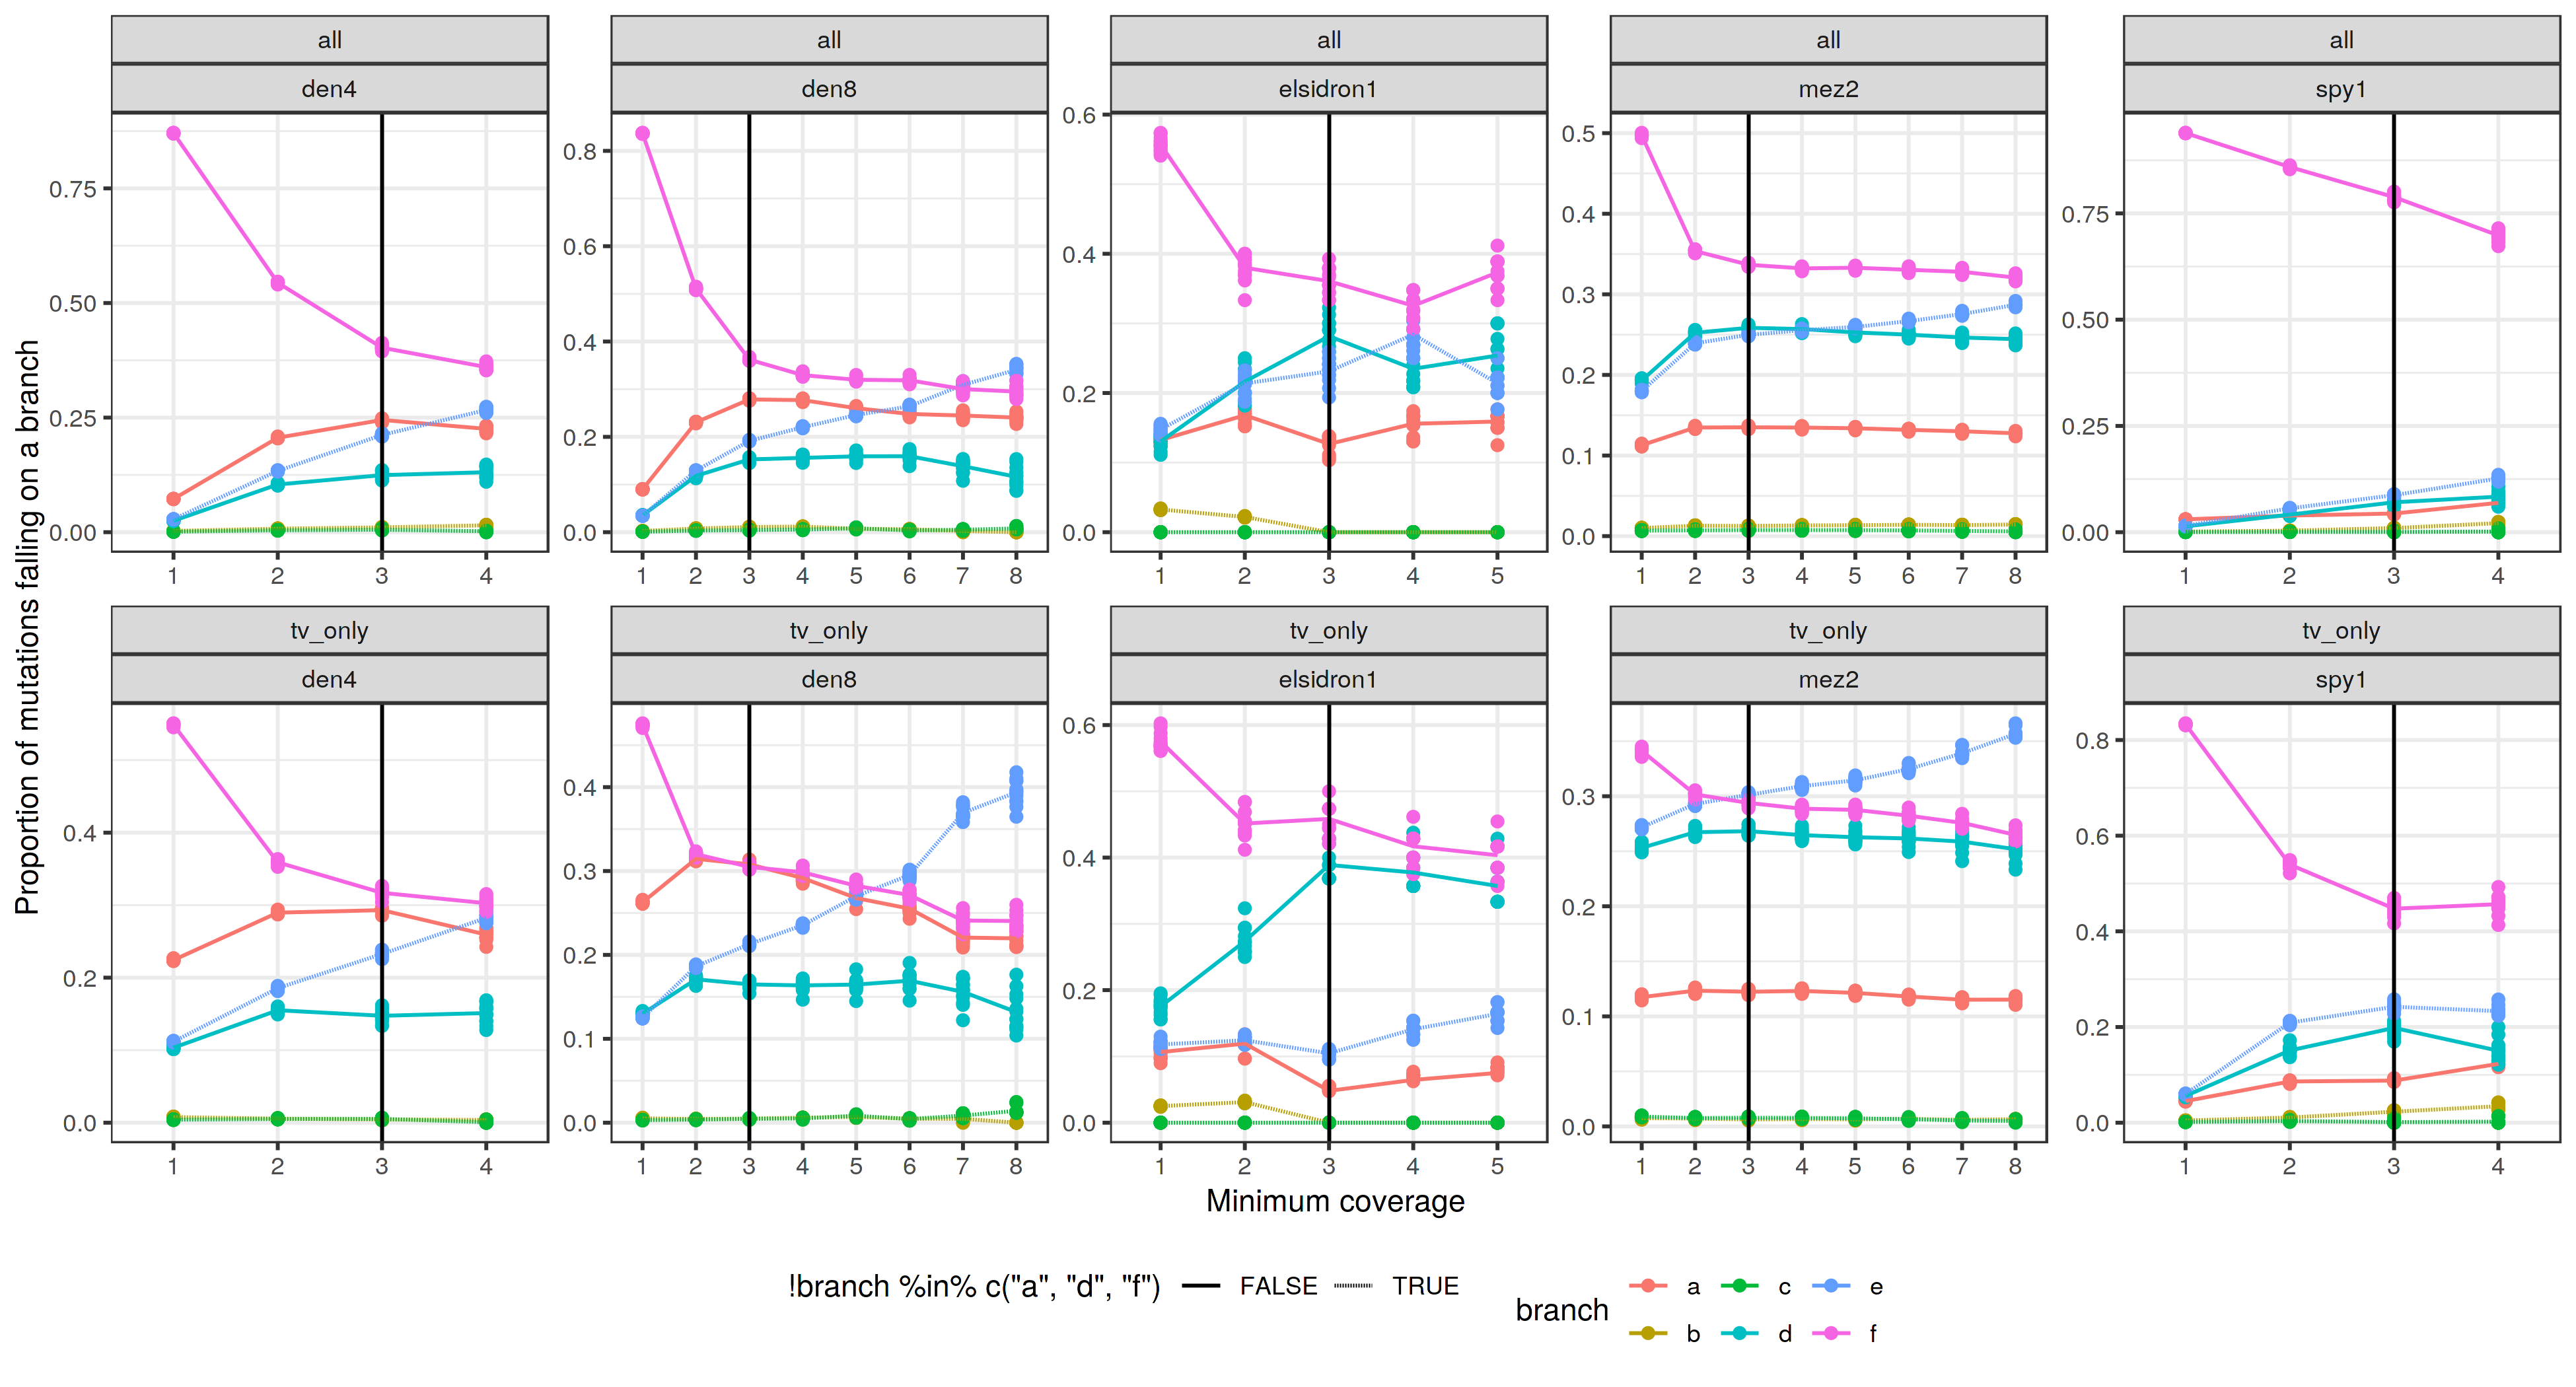

In [11]:
set_dim(13, 7)

tmrca_df %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
filter(afr %in% "a00", dp <= 8) %>%
filter(capture == "full" & arch %in% c("den8", "mez2", "spy1", "den4") | arch == "elsidron1") %>%
filter((dp <= 4 & arch == "den4") |
       (dp <= 10 & arch == "den8") |
       (dp <= 29 & arch == "mez2") |
       (dp <= 4 & arch == "spy1") |
       (dp <= 5 & arch == "elsidron1")) %>%
unnest(counts_arch) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
select(arch, afr, dp, tmrca_arch, alpha, a, b, c, d, e, f, total, n_muts, sites) %>%
gather(branch, count, -c(arch, afr, dp, alpha, tmrca_arch, total, n_muts, sites)) %>% 
mutate(prop = count / n_muts) %>% {
ggplot(., aes(as.factor(dp), prop, color = branch, fill = branch, group = branch)) +
    geom_point() +
    geom_line(data = group_by(., arch, afr, dp, sites, branch) %>% summarise_if(is.numeric, mean), size = 1 / 2,
              aes(linetype = !branch %in% c("a", "d", "f"))) +
    facet_wrap(sites ~ arch, scales = "free", ncol = 5) +
    geom_vline(xintercept = 3) +
    theme_bw() +
    xlab("Minimum coverage") +
    ylab("Proportion of mutations falling on a branch") +
    theme(legend.position = "bottom")
}

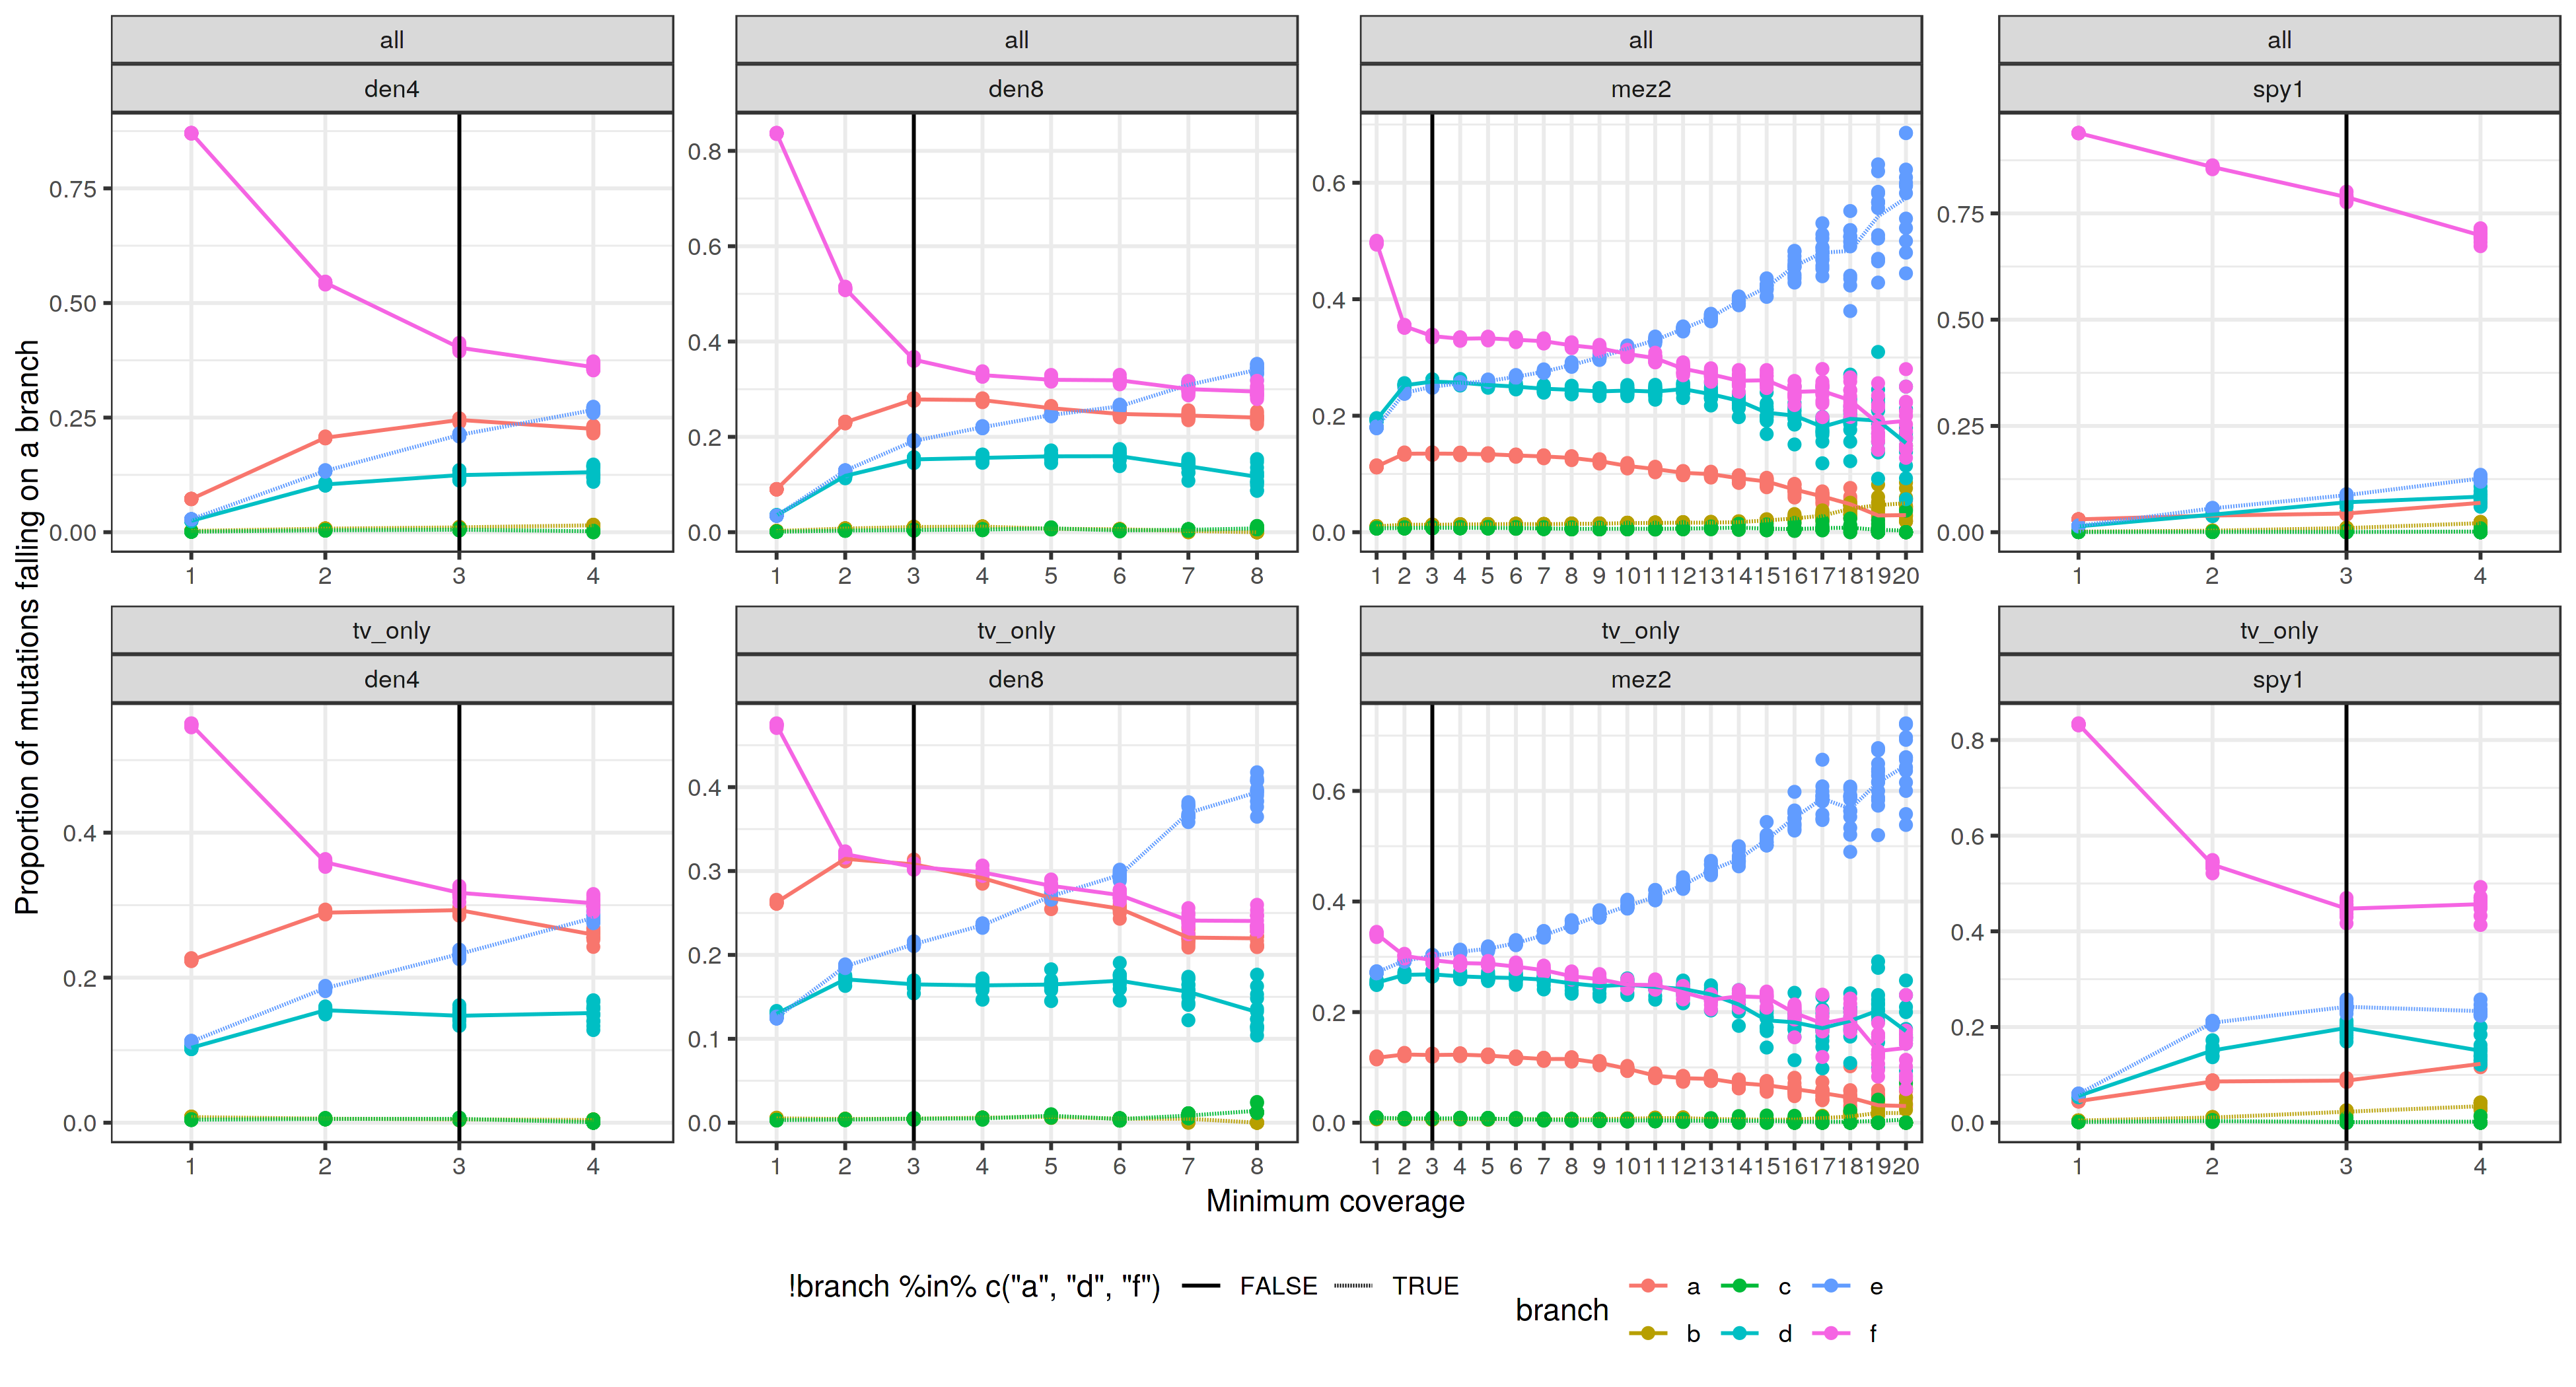

In [250]:
set_dim(13, 7)

tmrca_df %>%
filter(!is.infinite(alpha), !is.nan(alpha)) %>%
filter(afr %in% "a00") %>%
filter(capture == "full" & arch %in% c("den8", "mez2", "spy1", "den4")) %>%
filter((dp <= 4 & arch == "den4") |
       (dp <= 10 & arch == "den8") |
       (dp <= 29 & arch == "mez2") |
       (dp <= 4 & arch == "spy1")) %>%
unnest(counts_arch) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
select(arch, afr, dp, tmrca_arch, alpha, a, b, c, d, e, f, total, n_muts, sites) %>%
gather(branch, count, -c(arch, afr, dp, alpha, tmrca_arch, total, n_muts, sites)) %>% 
mutate(prop = count / n_muts) %>% {
ggplot(., aes(as.factor(dp), prop, color = branch, fill = branch, group = branch)) +
    geom_point() +
    geom_line(data = group_by(., arch, afr, dp, sites, branch) %>% summarise_if(is.numeric, mean), size = 1 / 2,
              aes(linetype = !branch %in% c("a", "d", "f"))) +
    facet_wrap(sites ~ arch, scales = "free", ncol = 4) +
    geom_vline(xintercept = 3) +
    theme_bw() +
    xlab("Minimum coverage") +
    ylab("Proportion of mutations falling on a branch") +
    theme(legend.position = "bottom")
}

^^^ `a` and `f` appear to level after `dp >= 3` which seems OK???

but `e` is increasing steadily - this is super weird and could be driving `a / (a + d + e)` higher at higher cutoffs?
* is the increased proportion of `e` branch the reference bias signal?


`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
“Removed 159 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 156 rows containing missing values (geom_point).”

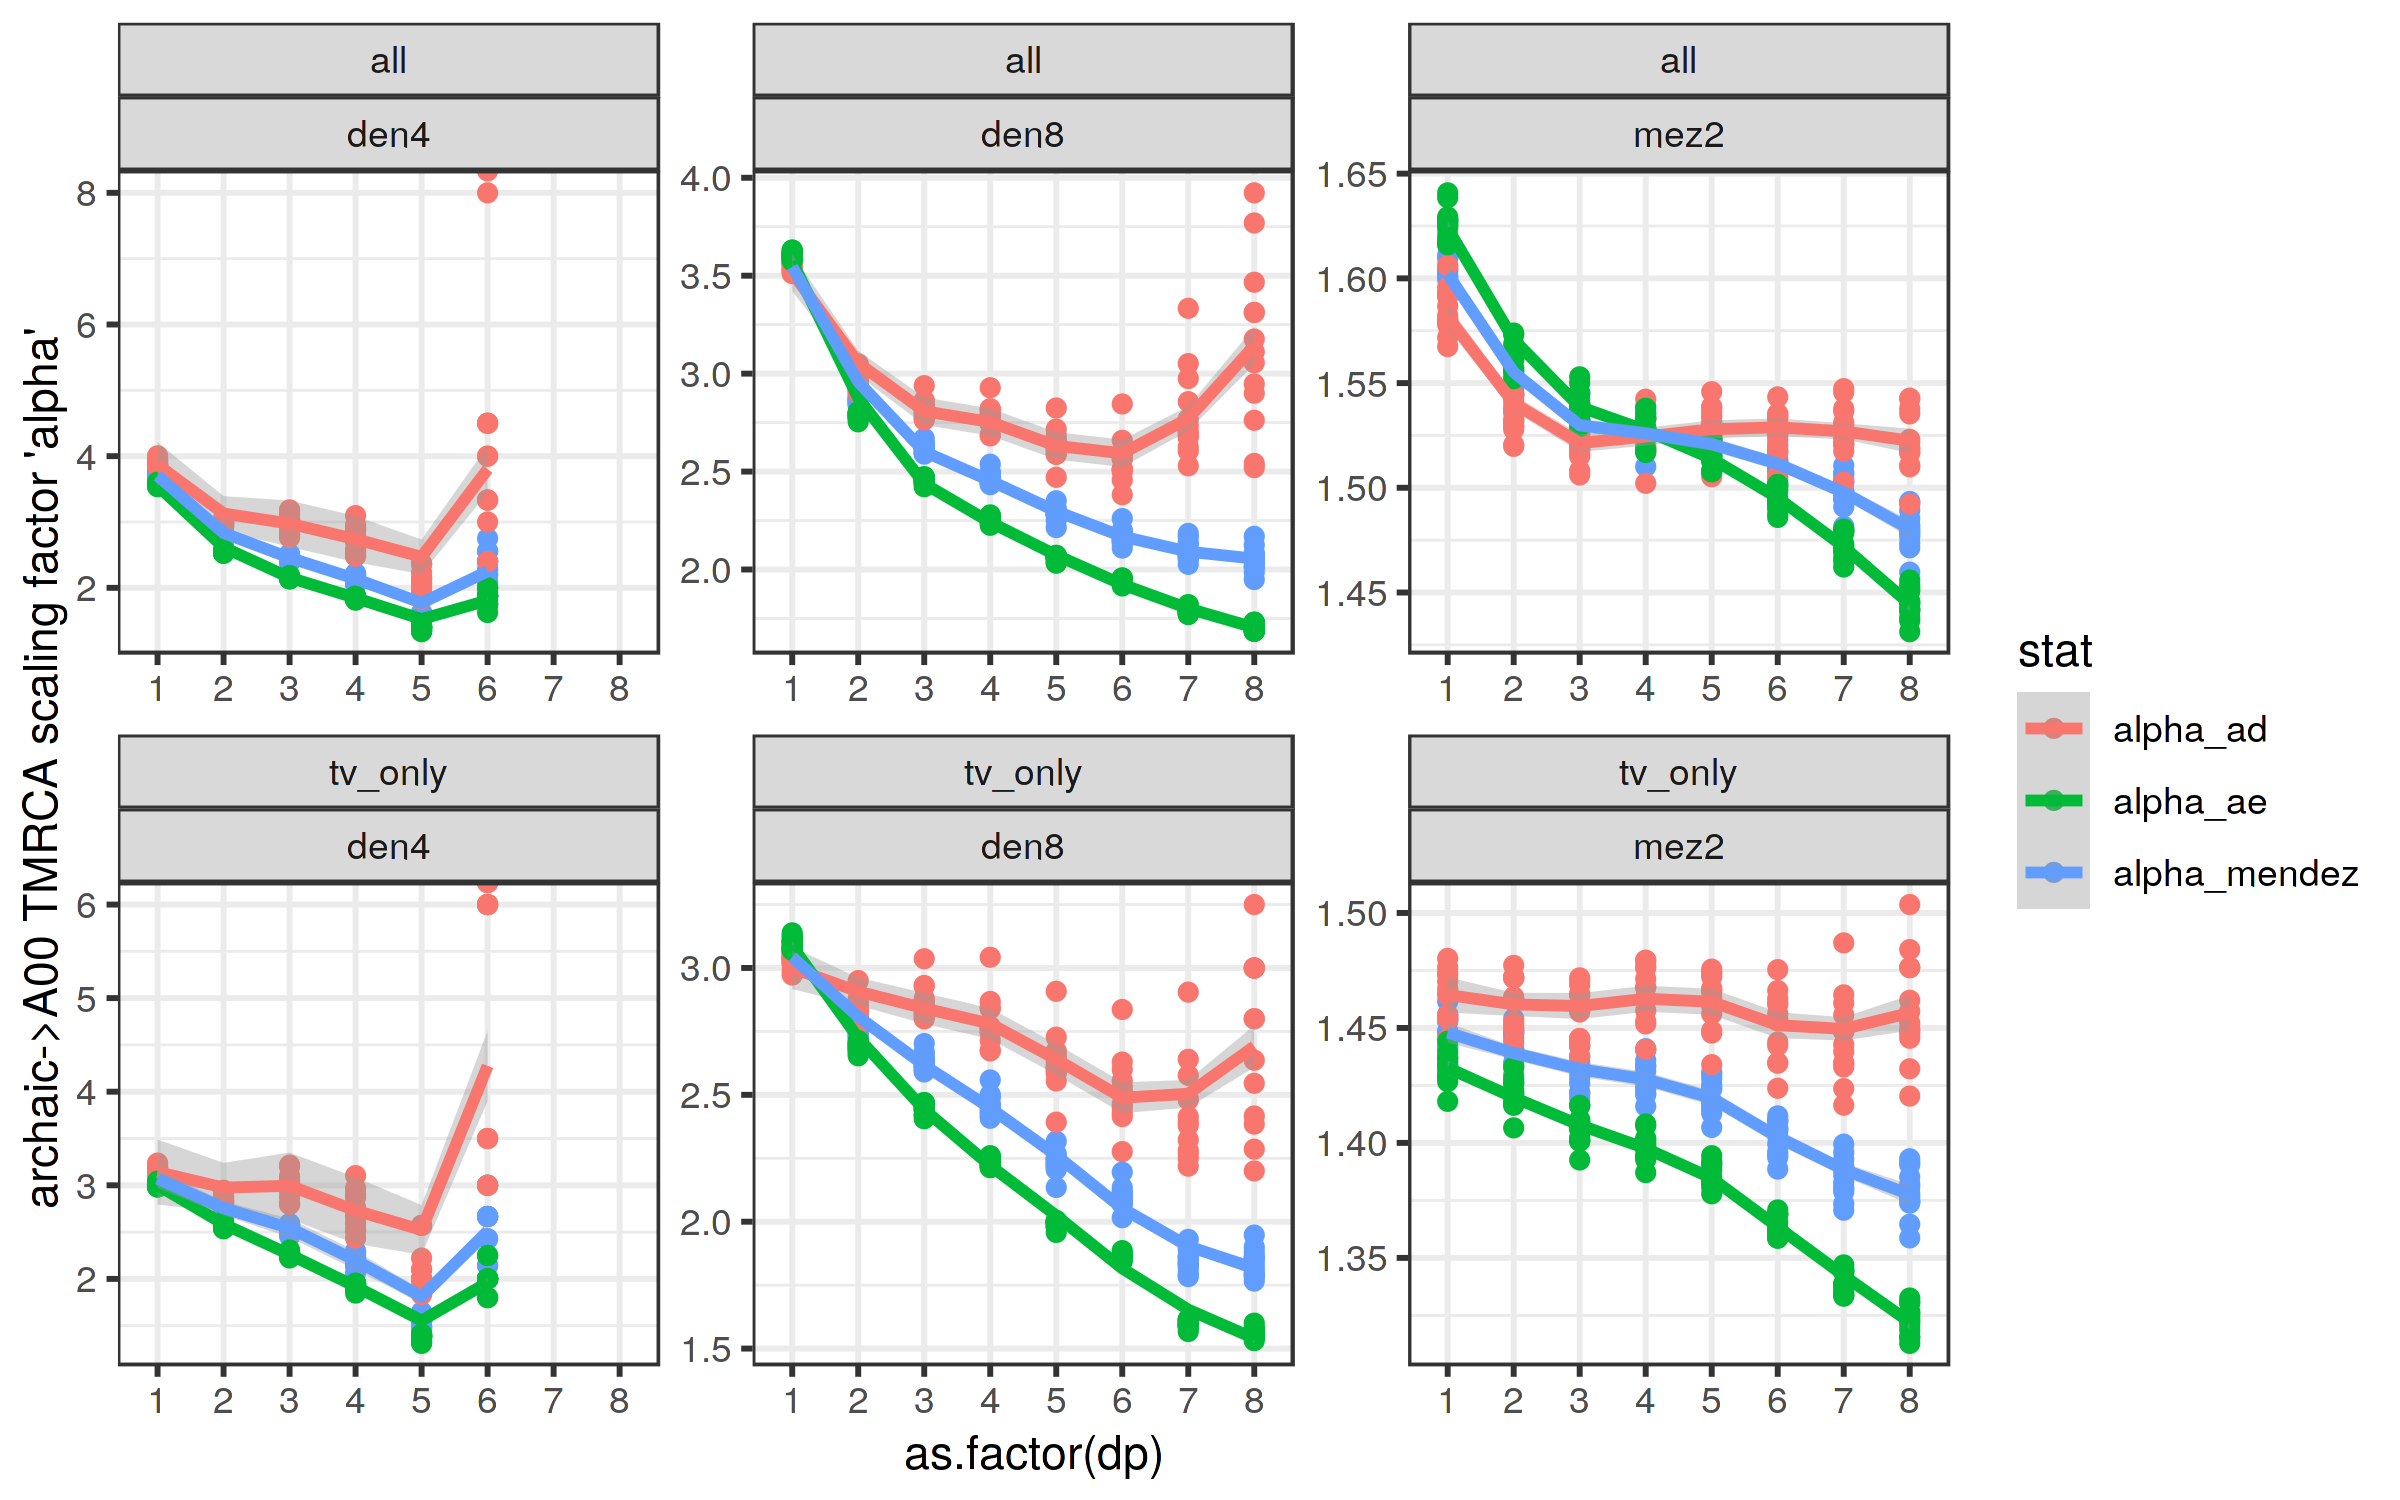

In [628]:
set_dim(8, 5)

tmrca_df %>%
filter(dp < 9, capture == "full", afr == "a00", arch %in% c("mez2", "den8", "den4")) %>% unnest(counts_arch) %>%
select(arch, dp, tmrca_arch, alpha_mendez = alpha, sites, tmrca_f, a, b, c, d, e, f) %>%
mutate(
    alpha_ad = (a + d) / d,
    alpha_ae = (a + e) / e
) %>%
select(arch, dp, sites, starts_with("alpha")) %>%
gather(stat, value, -arch, -dp, -sites) %>%
ggplot(aes(as.factor(dp), value, color = stat)) +
    geom_point() +
    geom_smooth(aes(group = stat)) +
    theme_bw() +
    facet_wrap(sites ~ arch, scales = "free") +
    ylab("archaic->A00 TMRCA scaling factor 'alpha'")

points here:

1. 3X coverage seems to remove most of the error effects nicely - best argument for using this cutoff in the middle panel.
2. TV-only removes all erors (TMRCA doesn't change) => sequencing errors minimal beyond aDNA damage.
3. Minimal effect of reference bias with increasing coverage??? Based on the Neanderthal line in the center panel, but significant bias in Denisova?

TMRCAs of A00 are overlapping the ones of other Africans, especially striking in the Lippold captures, but exome data looks weird too - too much noise in the data or not enough sequence to accumulate enough informative sites?

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


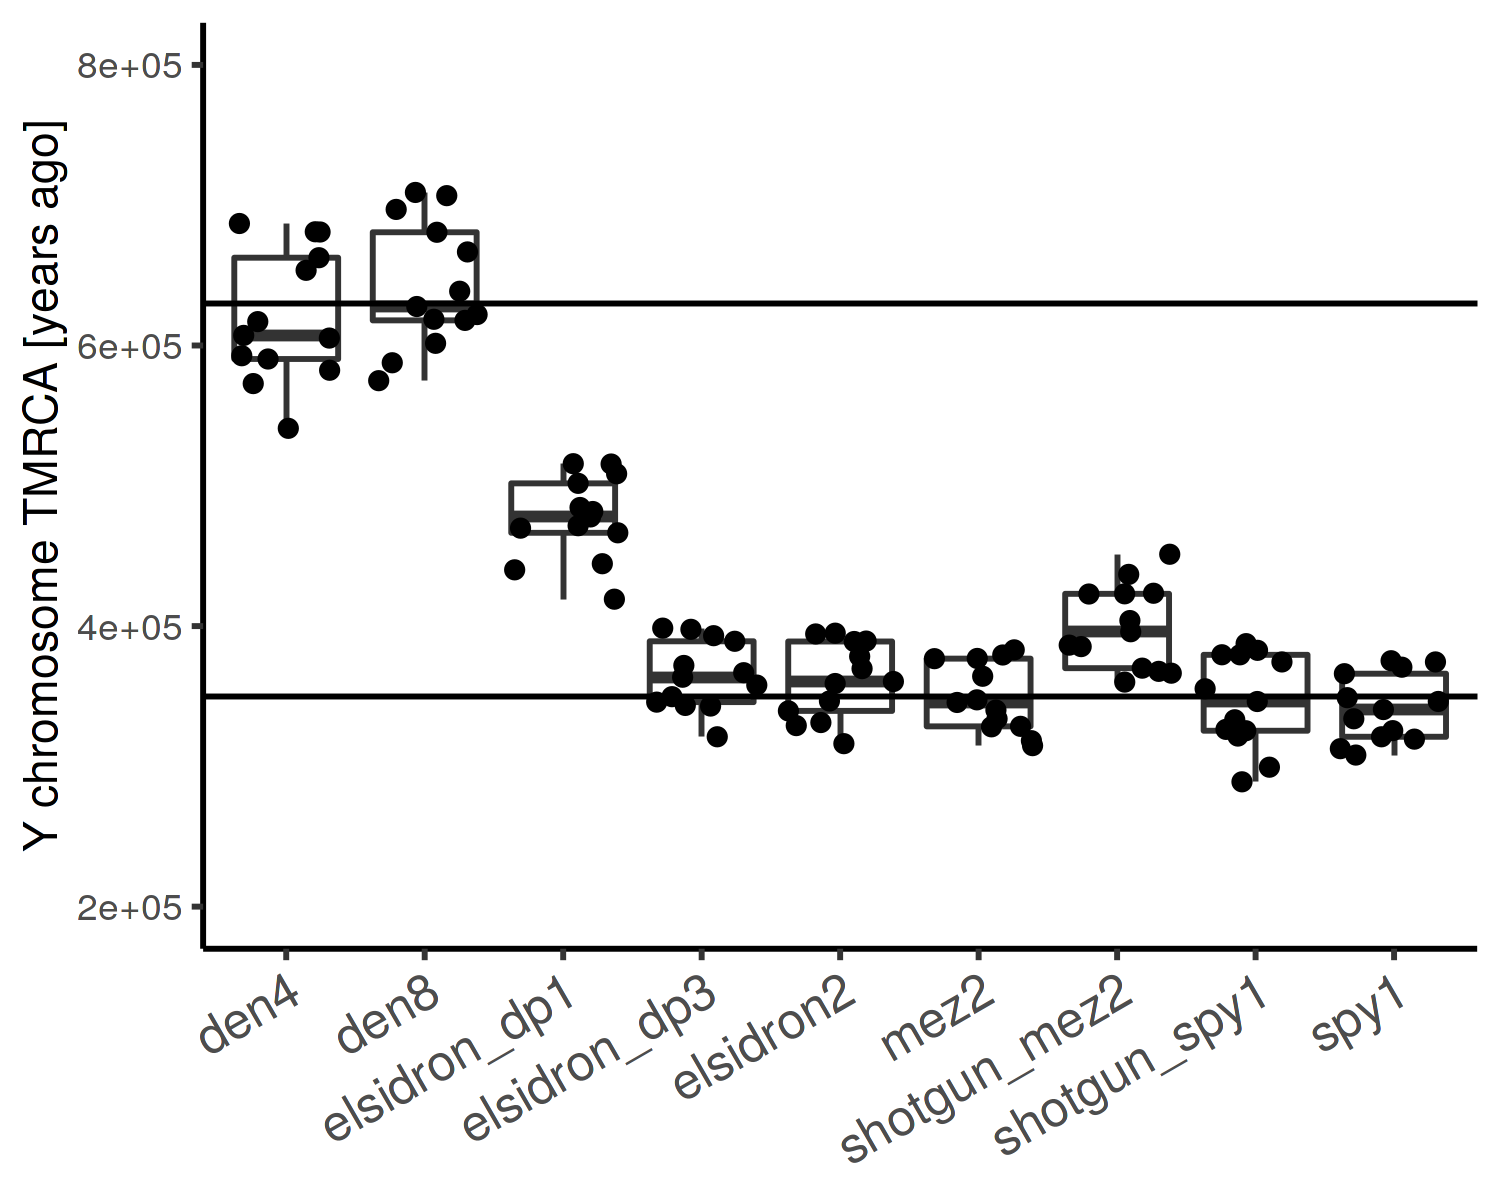

In [230]:
set_dim(5, 4)

tmrca_df %>%
    filter(afr == "a00") %>%
    filter(dp == 3 & sites == "tv_only" & capture == "full" & arch %in% c("den4", "den8", "mez2", "spy1", "shotgun_spy1", "shotgun_mez2") |
           dp == 3 & sites == "tv_only" & capture == "lippold" & arch == "elsidron2" |
           dp %in% c(1, 3) & sites == "all" & capture == "exome" & arch == "elsidron1") %>%
    mutate(arch = case_when(arch == "elsidron1" & dp == 1 ~ "elsidron_dp1",
                            arch == "elsidron1" & dp == 3 ~ "elsidron_dp3",
                            TRUE ~ arch)) %>%
    select(name = arch, tmrca = tmrca_arch) %>% 
ggplot(aes(name, tmrca)) +
    geom_boxplot() +
    geom_jitter() + 
    theme_classic() +
    xlab("") + ylab("Y chromosome TMRCA [years ago]") +
    guides(color = guide_legend("archaic human")) +
    scale_y_continuous(labels = comma) +
    geom_hline(yintercept = c(630000, 350000)) +
    theme(legend.position = "none",
          axis.text.x = element_text(hjust = 1, angle = 30, size = 12),
          axis.title.x = element_blank()) +
    ylim(c(200000, 800000))

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

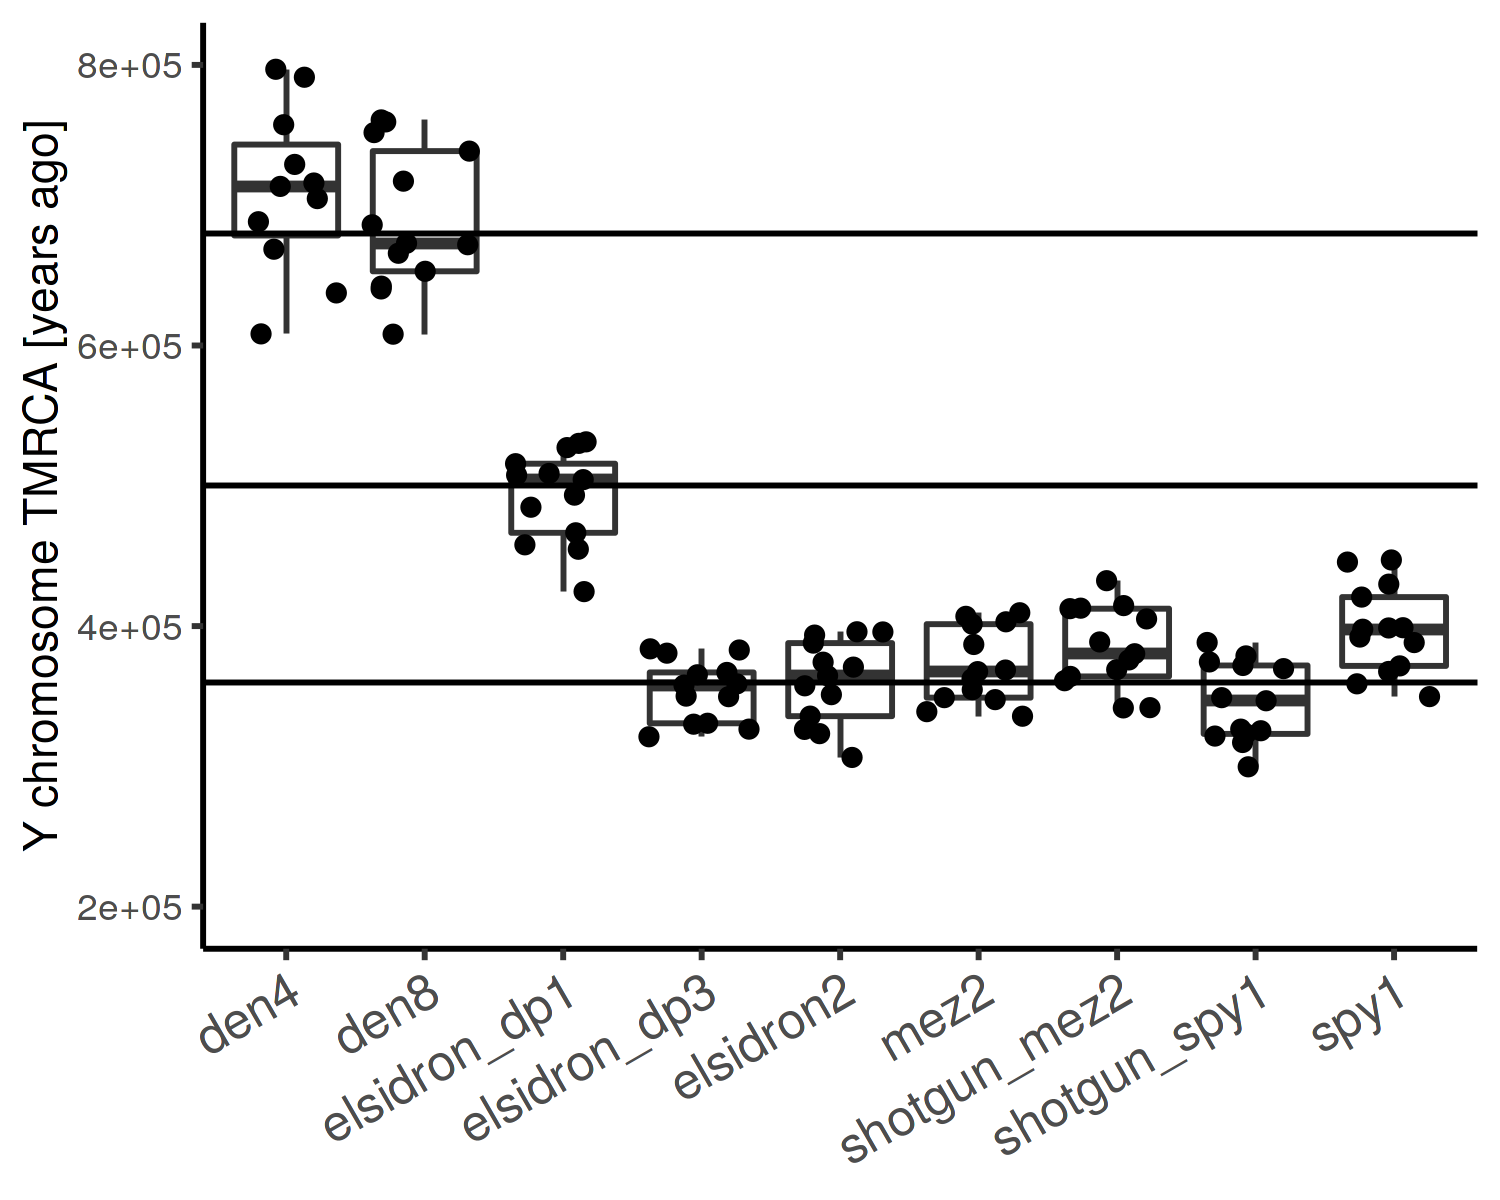

In [618]:
set_dim(5, 4)

tmrca_df %>%
    filter(afr == "a00") %>%
    filter(dp == 3 & sites == "all" & capture == "full" & arch %in% c("den4", "den8", "mez2", "spy1", "shotgun_spy1", "shotgun_mez2") |
           dp == 3 & sites == "all" & capture == "lippold" & arch == "elsidron2" |
           dp %in% c(1, 3) & sites == "all" & capture == "exome" & arch == "elsidron1") %>%
    mutate(arch = case_when(arch == "elsidron1" & dp == 1 ~ "elsidron_dp1",
                            arch == "elsidron1" & dp == 3 ~ "elsidron_dp3",
                            TRUE ~ arch)) %>%
    unnest(counts_arch) %>%
    mutate(alpha2 = (a + d) / d, tmrca_arch2 = alpha2 * tmrca_f) %>%
    select(name = arch, tmrca = tmrca_arch2) %>% 
ggplot(aes(name, tmrca)) +
    geom_boxplot() +
    geom_jitter() + 
    theme_classic() +
    xlab("") + ylab("Y chromosome TMRCA [years ago]") +
    guides(color = guide_legend("archaic human")) +
    scale_y_continuous(labels = comma) +
    geom_hline(yintercept = c(680000, 360000, 500000)) +
    theme(legend.position = "none",
          axis.text.x = element_text(hjust = 1, angle = 30, size = 12),
          axis.title.x = element_blank()) +
    ylim(c(200000, 800000))

In [36]:
library(scales)

colors <- c("red", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

tafr <- tmrca_df %>%
    filter(dp == 3, afr == "a00", arch == "den8", capture == "full", sites == "all") %>%
    select(name = afr, tmrca = tmrca_afr)

tarch <- tmrca_df %>%
    filter(afr == "a00") %>%
    filter(dp == 2 & sites == "tv_only" & capture == "full" & arch %in% c("den4", "den8", "mez2", "spy1", "shotgun_spy1", "shotgun_mez2") |
           dp == 2 & sites == "tv_only" & capture == "lippold" & arch == "elsidron2" |
           dp %in% c(1, 3) & sites == "all" & capture == "exome" & arch == "elsidron1") %>%
    mutate(arch = case_when(arch == "elsidron1" & dp == 1 ~ "elsidron_dp1",
                            arch == "elsidron1" & dp == 3 ~ "elsidron_dp3",
                            TRUE ~ arch)) %>%
    select(name = arch, tmrca = tmrca_arch, tmrca_arch2)
tmrca <- bind_rows(tafr, tarch) %>%
    mutate(set = case_when(name == "a00" ~ "A00",
                       name %in% c("den4", "den8") ~ "Denisovan",
                       name %in% c("spy1", "mez2", "elsidron2", "shotgun_spy1", "shotgun_mez2") ~ "Neanderthal",
                       TRUE ~ "other")) %>%
    mutate(name = case_when(name == "den4" ~ "Denisova 4 (1.6X)",
                            name == "den8" ~ "Denisova 8 (3.6X)",
                            name == "elsidron2" ~ "El Sidron (8X)",
                            name == "mez2" ~ "Mezmaiskaya 2 (15X)",
                            name == "spy1" ~ "Spy 1 (0.9X)",
                            name == "shotgun_spy1" ~ "Spy1 shot",
                            name == "shotgun_mez2" ~ "Mez2 shot",
                            name == "elsidron_dp1" ~ "El Sidron (3X, Mendez et al.)",
                            name == "elsidron_dp3" ~ "El Sidron (3X, Mendez at al., filtered)",
                            name == "a00" ~ "A00 lineage (21X)")) %>%
    mutate(name = fct_relevel(name, "El Sidron (8X)", "El Sidron (3X, Mendez et al.)",
                              "El Sidron (3X, Mendez at al., filtered)", "A00 lineage (21X)", after = Inf))


Attaching package: ‘scales’

The following objects are masked from ‘package:ychr’:

    col_factor, discard

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor



ERROR: Error in .f(.x[[i]], ...): object 'tmrca_arch2' not found


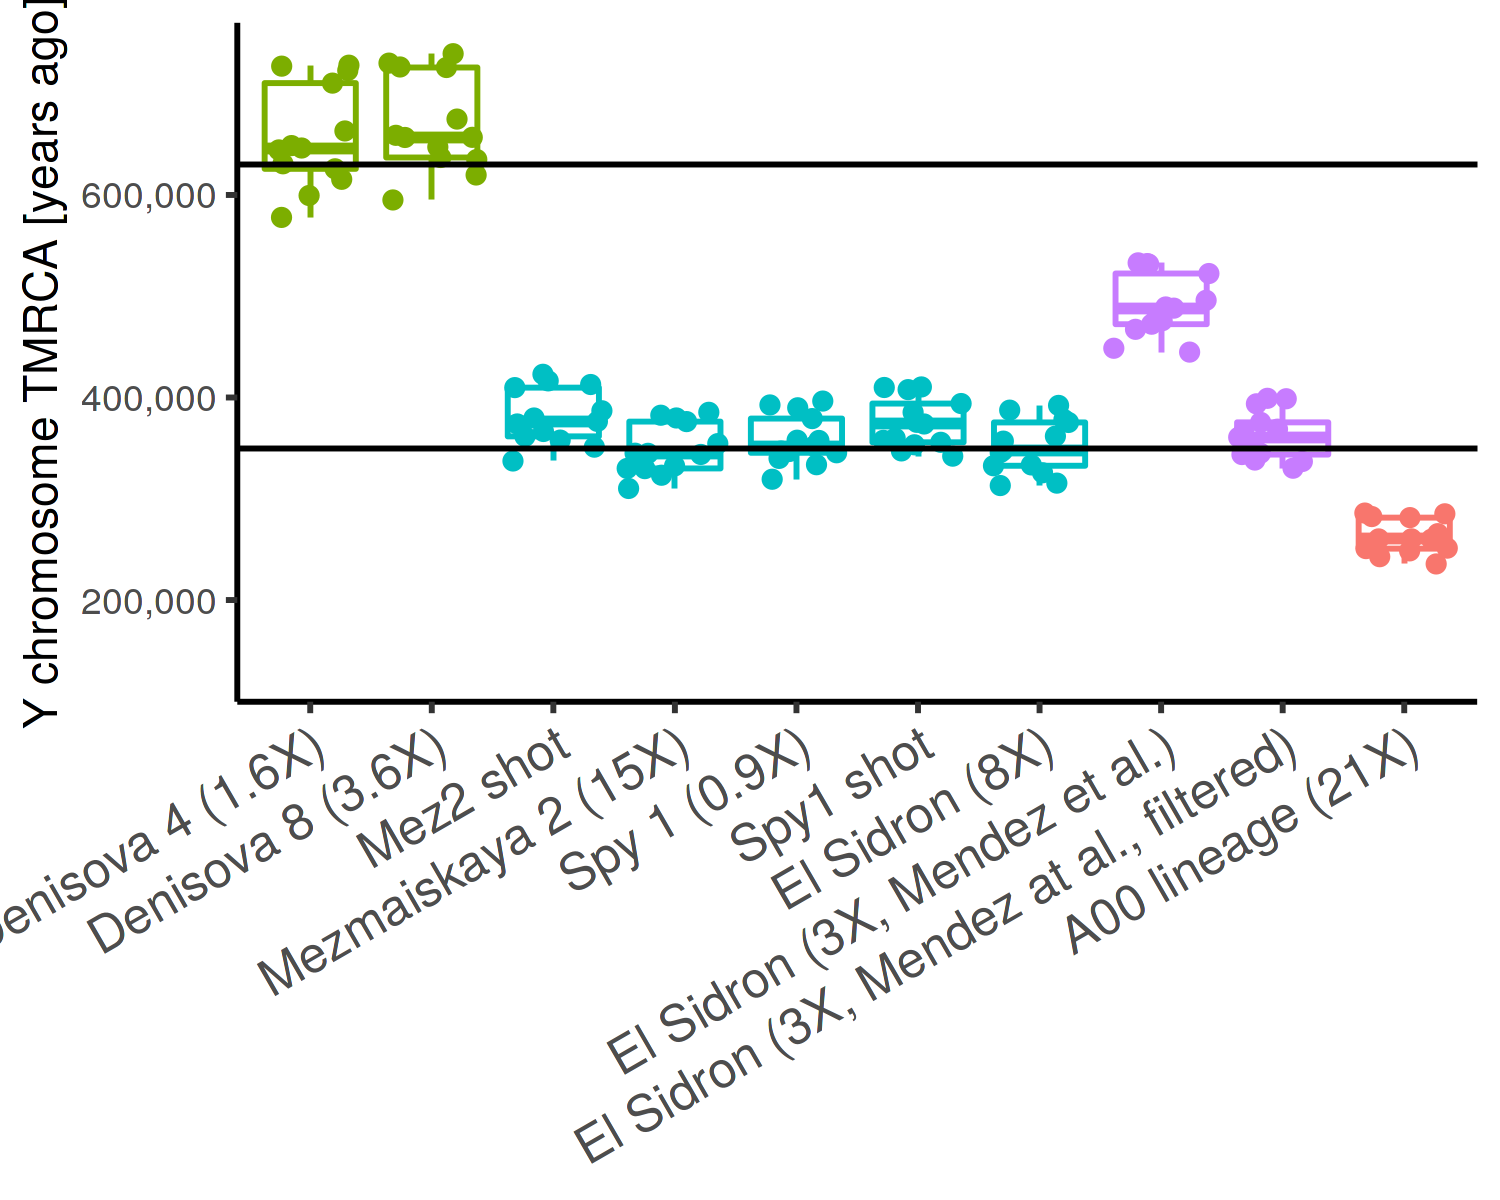

In [153]:
set_dim(5, 4)

tmrca %>%
ggplot(aes(name, tmrca, color = set)) +
    geom_boxplot() +
    geom_jitter() + 
    theme_classic() +
    xlab("") + ylab("Y chromosome TMRCA [years ago]") +
    expand_limits(y = 130000) +
    guides(color = guide_legend("archaic human")) +
    scale_y_continuous(labels = comma) +
    geom_hline(yintercept = c(630000, 350000)) +
    theme(legend.position = "none",
          axis.text.x = element_text(hjust = 1, angle = 30, size = 12),
          axis.title.x = element_blank())

Warning message:
“Removed 13 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 13 rows containing missing values (geom_point).”

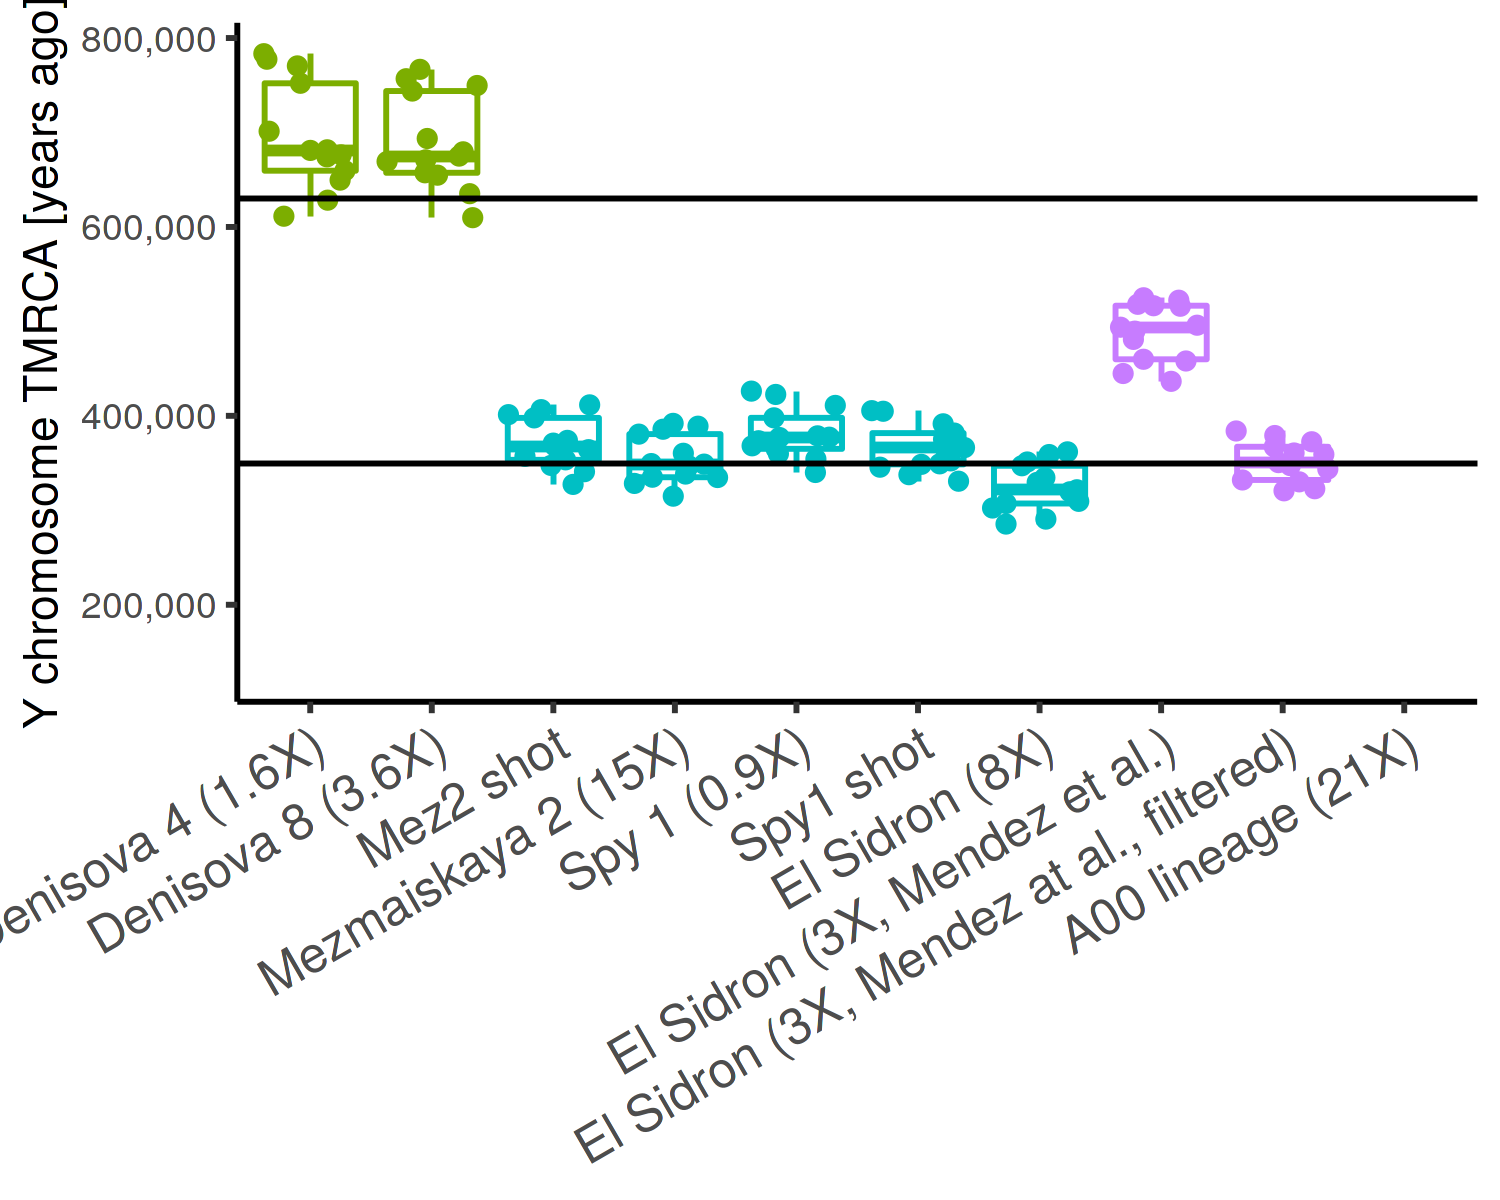

In [154]:
set_dim(5, 4)

tmrca %>%
ggplot(aes(name, tmrca_arch2, color = set)) +
    geom_boxplot() +
    geom_jitter() + 
    theme_classic() +
    xlab("") + ylab("Y chromosome TMRCA [years ago]") +
    expand_limits(y = 130000) +
    guides(color = guide_legend("archaic human")) +
    scale_y_continuous(labels = comma) +
    geom_hline(yintercept = c(630000, 350000)) +
    theme(legend.position = "none",
          axis.text.x = element_text(hjust = 1, angle = 30, size = 12),
          axis.title.x = element_blank())

In [86]:
x %<-% read_vcf("../data/vcf/full_shotgun_mez2.vcf.gz", mindp = 3, maxdp = 1)

In [87]:
y %<-% read_vcf("../data/vcf/full_mez2.vcf.gz", mindp = 3, maxdp = 1)

In [90]:
head(x)

chrom pos     REF ALT shotgun_mez2
1 Y     2649835 T       0           
2 Y     2649836 T       0           
3 Y     2649837 T       0           
4 Y     2649838 A       0           
5 Y     2649839 T       0           
6 Y     2649840 G       0

In [91]:
df = full_join(x, y)

Joining, by = c("chrom", "pos", "REF", "ALT")


In [92]:
head(df)

chrom pos     REF ALT shotgun_mez2 mez2
1 Y     2649835 T       0             0  
2 Y     2649836 T       0             0  
3 Y     2649837 T       0             0  
4 Y     2649838 A       0             0  
5 Y     2649839 T       0             0  
6 Y     2649840 G       0            NA

In [93]:
filter(df, shotgun_mez2 != mez2)

chrom pos REF ALT shotgun_mez2 mez2